In [1]:
import sys, os
sys.path.append(os.path.abspath("../../"))

In [19]:
from core_elts import lib as core
from snia_discrete_elements import lib as snia_discrete_elts
from snia_discrete_no_elements import lib as snia_discrete_no_elts
from snia_continuous_elements import lib as snia_continuous_elts
from snia_continuous_no_elements import lib as snia_continuous_no_elts
from snii_discrete_elements import lib as snii_discrete_elts
from snii_discrete_no_elements import lib as snii_discrete_no_elts
from snii_continuous_elements import lib as snii_continuous_elts
from snii_continuous_no_elements import lib as snii_continuous_no_elts
from agb_elements import lib as agb_elements
from agb_no_elements import lib as agb_no_elements

In [20]:
core.detailed_enrichment_init()
snia_discrete_elts.detailed_enrichment_init()
snia_continuous_elts.detailed_enrichment_init()
snii_discrete_elts.detailed_enrichment_init()
snii_discrete_no_elts.detailed_enrichment_init()
snii_continuous_elts.detailed_enrichment_init()
snii_continuous_no_elts.detailed_enrichment_init()
agb_elements.detailed_enrichment_init()
agb_no_elements.detailed_enrichment_init()

In [21]:
from collections import defaultdict
import numpy as np
from tabulation import Lifetimes
from tabulation import IMF
from scipy import integrate
from tqdm import tqdm_notebook as tqdm

import betterplotlib as bpl
bpl.presentation_style()

In [5]:
bpl.presentation_style()

In [6]:
lt = Lifetimes("Raiteri_96")
imf = IMF("Kroupa", 0.1, 50, total_mass=1)

First try to see if the integration is okay.

In [7]:
frac_E = 3.25E49  # ergs / solar mass
# frac_N_SN = 0.0109743508039993  # SN / solar mass

In [8]:
frac_N_SN_II = integrate.quad(imf.normalized_dn_dm, 8.0, 50.0)[0]

In [9]:
integrate.quad(imf.normalized_dn_dm, 0.1, 50.0)[0]

1.6386543349407943

In [10]:
core.imf_integral_py(0.1, 50.0)

1.6386543355363412

In [11]:
frac_N_SN_Ia = 1.6E-3

In [12]:
for _ in range(100):
    m_low, m_high = sorted(np.random.uniform(0.1, 0.9, 2))
    
    int_1 = integrate.quad(imf.normalized_dn_dm, m_low, m_high)[0]
    int_2 = core.imf_integral_py(m_low, m_high)
    
    if abs(int_1/int_2 - 1.0) > 0.01:
        print("{:.3f} {:.3f}\n{:.10f}\n{:.10}\n{:.10f}".format(m_low, m_high, int_1, int_2, int_1 / int_2))
        print("----")

In [13]:
for _ in range(100):
    m_low, m_high = sorted(np.random.uniform(0.1, 50.0, 2))
    
    int_1 = integrate.quad(imf.normalized_dn_dm, m_low, m_high)[0]
    int_2 = core.imf_integral_py(m_low, m_high)
    if abs(int_1/int_2 - 1.0) > 0.01:
        print("{:.1f} {:.1f}\n{:.10f}\n{:.10}\n{:.10f}".format(m_low, m_high, int_1, int_2, int_1 / int_2))
        print("----")

Then attempt to build a SN history

In [14]:
def ceil_to_nearest(num, scale):
    test_values = np.arange(0, num+2*scale, scale)
    for val in test_values:
        if val - scale > num:
            return val

In [15]:
dt_sn = 1E5
dt_agb = 1E7

In [16]:
times = dict()
turnoff_masses = dict()
def generate_times(zs):
    for z in zs:
        split = ceil_to_nearest(lt.lifetime(8.0, z), dt_sn)
        times[z] = np.concatenate([np.arange(3E6, split, dt_sn),
                                   np.arange(split, 14E9, dt_agb)])
        turnoff_masses[z] = [lt.turnoff_mass(t, z) for t in tqdm(times[z])]

In [17]:
generate_times([0.02, 0.01, 0.004, 0.001, 0.0005, 0.0001])

In [27]:
solar_metallicities = {"Z":0.02, "S":4.79E-4, "Ca":6.41E-5, "Fe":1.23E-3}

In [28]:
elts = ["C", "N", "O", "Mg", "S", "Ca", "Fe"]
all_fields = elts + ["Z_II", "Z_Ia", "Z_AGB", "Z", "total", "E", "N_SN", "N_SN_left"]
sn_ii_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
              "Z_II": 7, "Z": 7, "total": 8, "E": 9, "N_SN": 10, "N_SN_left": 11}
agb_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
           "Z_AGB": 7, "Z": 7, "total":8}
sn_ia_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
              "Z_Ia": 7, "Z": 7, "total": 7, "E": 8, "N_SN_left": 9}
# The raw yields doesn't return some elements, since those are scaled based on
# the metallicity of the star
agb_idxs_yields = {"C": 0, "N": 1, "O":2, "Mg":3, "Z_AGB":4, "total": 5}

class SNHistory(object):
    def __init__(self, stellar_mass, z, discrete=True, verbose=False):
        self.mass = stellar_mass
        self.z = z
        
        self.times = times[z]
        self.turnoff_masses = turnoff_masses[z]
        
        self.discrete = discrete
        
        # handle which functions to call
        if discrete:
            self.sn_ii_func = snii_discrete_elts.get_ejecta_sn_ii_py
            self.sn_ia_func = snia_discrete_elts.sn_ia_core_py
        else:
            self.sn_ii_func = snii_continuous_elts.get_ejecta_sn_ii_py
            self.sn_ia_func = snia_continuous_elts.sn_ia_core_py
        
        self.sn_ia_start = lt.lifetime(8.0, self.z)
        
        self.yields = defaultdict(list)
        self.cumulative = defaultdict(list)
        
        self.yields_sn_ii = defaultdict(list)
        self.cumulative_sn_ii = defaultdict(list)
        
        self.yields_sn_ia = defaultdict(list)
        self.cumulative_sn_ia = defaultdict(list)
        
        self.yields_agb = defaultdict(list)
        self.cumulative_agb = defaultdict(list)
        
        self.handle_history(verbose)
        
    def handle_history(self, verbose=False):
        self.unexploded_sn_ii = 0
        self.unexploded_sn_ia = 0
        
        for idx in range(len(self.turnoff_masses) - 1):
            m_now  = self.turnoff_masses[idx]
            m_next = self.turnoff_masses[idx+1]
            age_now = self.times[idx]
            dt = self.times[idx+1] - self.times[idx]
            sn_ii_yields = self.sn_ii_func(self.unexploded_sn_ii, m_now, m_next, self.mass, self.z)
            agb_yields = agb_elements.get_ejecta_agb_py(m_now, m_next, self.mass, self.z,
                                                        (self.z/0.02) * solar_metallicities["S"],
                                                        (self.z/0.02) * solar_metallicities["Ca"],
                                                        (self.z/0.02) * solar_metallicities["Fe"])
            sn_ia_yields = self.sn_ia_func(self.unexploded_sn_ia, age_now, dt,
                                           self.mass, self.z, self.sn_ia_start)
            
            # handle SN numbers
            if self.discrete:
                self.unexploded_sn_ii = sn_ii_yields[sn_ii_idxs["N_SN_left"]]
                self.unexploded_sn_ia = sn_ia_yields[sn_ia_idxs["N_SN_left"]]
#             print(m_now, m_next, yields[self.idxs["N_SN"]], self.unexploded_sn)
            if verbose:
                print("{:8.4f} {:8.4f} {:8.4f} {:8.4f}".format(m_now, m_next, sn_ii_yields[sn_ii_idxs["N_SN"]], self.unexploded_sn))
            
            for field in all_fields:
                if field in sn_ii_idxs:
                    this_sn_ii_yield = sn_ii_yields[sn_ii_idxs[field]]
                else:
                    this_sn_ii_yield = 0
                    
                if field in sn_ia_idxs:
                    this_sn_ia_yield = sn_ia_yields[sn_ia_idxs[field]]
                elif field == "N_SN":
                    this_sn_ia_yield = sn_ia_yields[sn_ia_idxs["E"]] / 2E51
                else:
                    this_sn_ia_yield = 0
                    
                
                if field in agb_idxs:
                    this_agb_yield = agb_yields[agb_idxs[field]]
                else:
                    this_agb_yield = 0
                
                total_yield = this_sn_ii_yield + this_sn_ia_yield + this_agb_yield
                
                self.yields_sn_ii[field].append(this_sn_ii_yield / dt)
                self.yields_sn_ia[field].append(this_sn_ia_yield / dt)
                self.yields_agb[field].append(this_agb_yield / dt)
                self.yields[field].append(total_yield / dt)
                
                if len(self.cumulative[field]) == 0:
                    self.cumulative[field].append(total_yield)
                else:
                    self.cumulative[field].append(self.cumulative[field][-1] + total_yield)
                    
                if len(self.cumulative_sn_ii[field]) == 0:
                    self.cumulative_sn_ii[field].append(this_sn_ii_yield)
                else:
                    self.cumulative_sn_ii[field].append(self.cumulative_sn_ii[field][-1] + this_sn_ii_yield)
                    
                if len(self.cumulative_sn_ia[field]) == 0:
                    self.cumulative_sn_ia[field].append(this_sn_ia_yield)
                else:
                    self.cumulative_sn_ia[field].append(self.cumulative_sn_ia[field][-1] + this_sn_ia_yield)
                    
                if len(self.cumulative_agb[field]) == 0:
                    self.cumulative_agb[field].append(this_agb_yield)
                else:
                    self.cumulative_agb[field].append(self.cumulative_agb[field][-1] + this_agb_yield)
        

In [29]:
def plot_history(field, mass, z, verbose=False):
    plot_times = times[z][1:]
    fig, ax = bpl.subplots()
    
    left_limit = 1E6
    right_limit = max(plot_times)
    
    ax.set_xscale("log")
#     if field not in ["N_SN"]:
#         ax.set_yscale("log")
    if field == "E":
        label = "E [ergs] Cumulative"
    elif field =="N_SN":
        label = "Number of Supernovae"
    else: 
        label = "Cumulative " + field + " Ejecta [$M_\odot$]"
    ax.add_labels("Age [yr]", label)
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "} M_\odot$" + "\nZ = {}".format(z), 
                     "upper left")
    
    if field == "E":
        ax.axhline(frac_E * mass, ls=":")
    if field == "N_SN":
        expected_ii = frac_N_SN_II * mass
        expected_ia = frac_N_SN_Ia * mass
        ax.axhline(expected_ii, ls=":")
        ax.axhline(expected_ia, ls=":")
        ax.add_text(left_limit, expected_ii, "{:.3f}".format(expected_ii), 
                    ha="left", va="bottom", fontsize=13)
        ax.add_text(left_limit, expected_ia, "{:.3f}".format(expected_ia), 
                    ha="left", va="bottom", fontsize=13)
    
    for label in ["Continuous", "Discrete"]:
        discrete = label == "Discrete"
        if discrete:
            lw = 2
        else:
            lw = 4
        this_obj = SNHistory(mass, z, discrete, verbose)
        ax.plot(plot_times, this_obj.cumulative[field], lw=lw, label="Total " + label)
        ax.plot(plot_times, this_obj.cumulative_sn_ii[field], lw=lw, label="SN II " + label)
        ax.plot(plot_times, this_obj.cumulative_sn_ia[field], lw=lw, label="SN Ia " + label)
        if field != "N_SN":
            ax.plot(plot_times, this_obj.cumulative_agb[field], lw=lw, label="AGB")
    
#         if field == "N_SN":  
#             true_sn_ii = this_obj.cumulative_sn_ii[field][-1]
#             ax.add_text(right_limit, true_sn_ii, "{:.3f}".format(true_sn_ii), 
#                         ha="right", va="bottom", fontsize=13)

#             true_sn_ia = this_obj.cumulative_sn_ia[field][-1]
#             ax.add_text(right_limit, true_sn_ia, "{:.3f}".format(true_sn_ia), 
#                         ha="right", va="bottom", fontsize=13)
            
    ax.legend(loc=7)
        
    ax.set_limits(left_limit, right_limit, 0)
    fig.savefig("../plots/discrete_{}_m_{:.1e}_dt_{:.1g}_z_{:.5f}.png".format(field, mass, dt_sn, z))

In [30]:
def plot_history_energy(mass, z, n):
    plot_times = times[z][1:]
    fig, ax = bpl.subplots()
    
    left_limit = 1E6
    right_limit = max(plot_times)
    
    ax.set_xscale("log")
    ax.add_labels("Age [yr]", "E [ergs] Cumulative")
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "} M_\odot$" + "\nZ = {}".format(z), 
                     "upper left")
    
    ax.axhline(frac_E * mass, ls=":")
    
    for i in range(n):
        c = bpl.color_cycle[i]
        if i == 0:
            label_total = "Total"
            label_ii = "SN II"
            label_ia = "SN Ia"
        else:
            label_total = None
            label_ii = None
            label_ia = None
        
        for label in ["Continuous", "Discrete"]:
            discrete = label == "Discrete"
            if discrete:
                lw = 2
            else:
                lw = 4
            this_obj = SNHistory(mass, z, discrete, False)
            ax.plot(plot_times, this_obj.cumulative["E"], c=c, ls="-", lw=lw, label=label_total)
            ax.plot(plot_times, this_obj.cumulative_sn_ii["E"], c=c, ls=":", lw=lw, label=label_ii)
            ax.plot(plot_times, this_obj.cumulative_sn_ia["E"], c=c, ls="--", lw=lw, label=label_ia)
            
    ax.legend()
        
    ax.set_limits(left_limit, right_limit, 0)
    fig.savefig("../plots/discrete_E_m_{:.1e}_dt_{:.1g}_z_{:.5f}.png".format(mass, dt_sn, z))

In [31]:
def plot_rates(field, mass, z):
    plot_times = times[z][1:]
    fig, ax = bpl.subplots()
    
    ax.set_xscale("log")
#     if field not in ["N_SN"]:
#         ax.set_yscale("log")
    ax.add_labels("Age [yr]", field + " Per Year")
    ax.easy_add_text("M = $10^{" + str(round(np.log10(mass), 2)) + "}$", "lower right")
    
    for label in ["Continuous", "Discrete"]:
        discrete = label == "Discrete"
        if discrete:
            lw = 2
        else:
            lw = 4
        this_obj = SNHistory(mass, z, discrete)

        ax.plot(plot_times, this_obj.yields[field], lw=lw, label="Total " + label)
        ax.plot(plot_times, this_obj.yields_sn_ii[field], lw=lw, label="SN II " + label)
        ax.plot(plot_times, this_obj.yields_sn_ia[field], lw=lw, label="SN Ia " + label)
        if field != "N_SN":
            ax.plot(plot_times, this_obj.yields_agb[field], label="AGB " + label)
        else:
            rates = [snia_discrete_elts.get_sn_ia_rate_py(t, lt.lifetime(8.0, z))*mass for t in plot_times]
            ax.plot(plot_times, rates, label='SN Ia rate', ls=":")

    ax.set_limits(1E6, max(plot_times), 0)
    ax.axvline(lt.lifetime(8.0, z), ls=":")
    ax.legend()

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


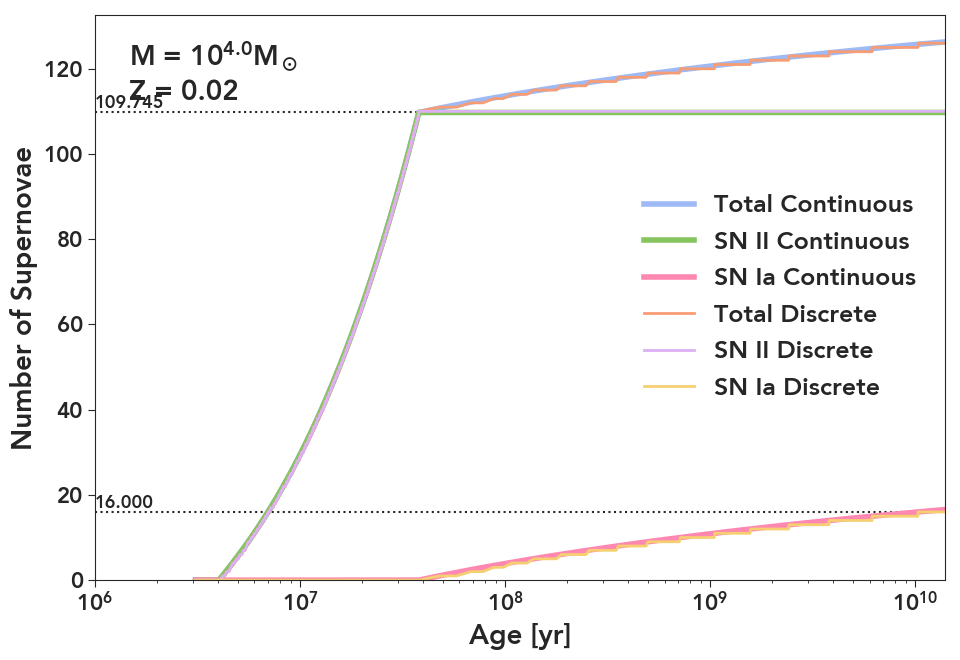

In [32]:
plot_history("N_SN", 10000, 0.02)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


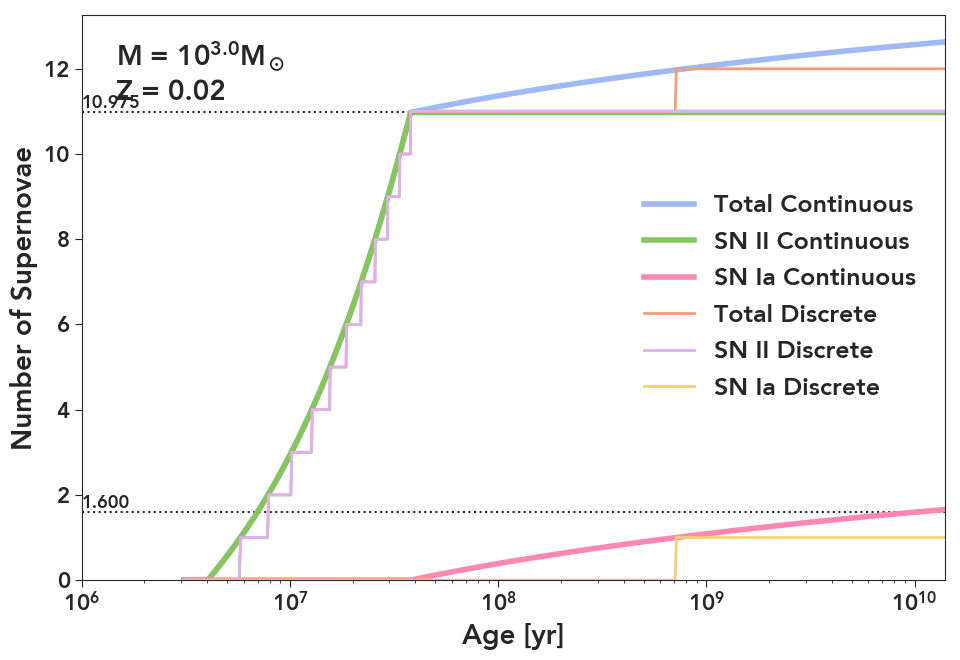

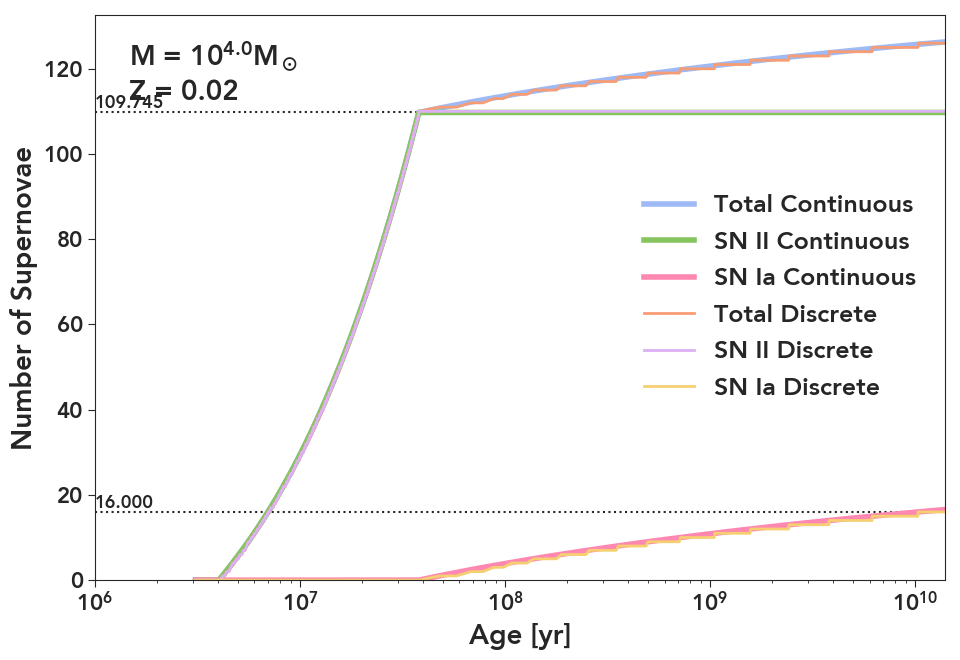

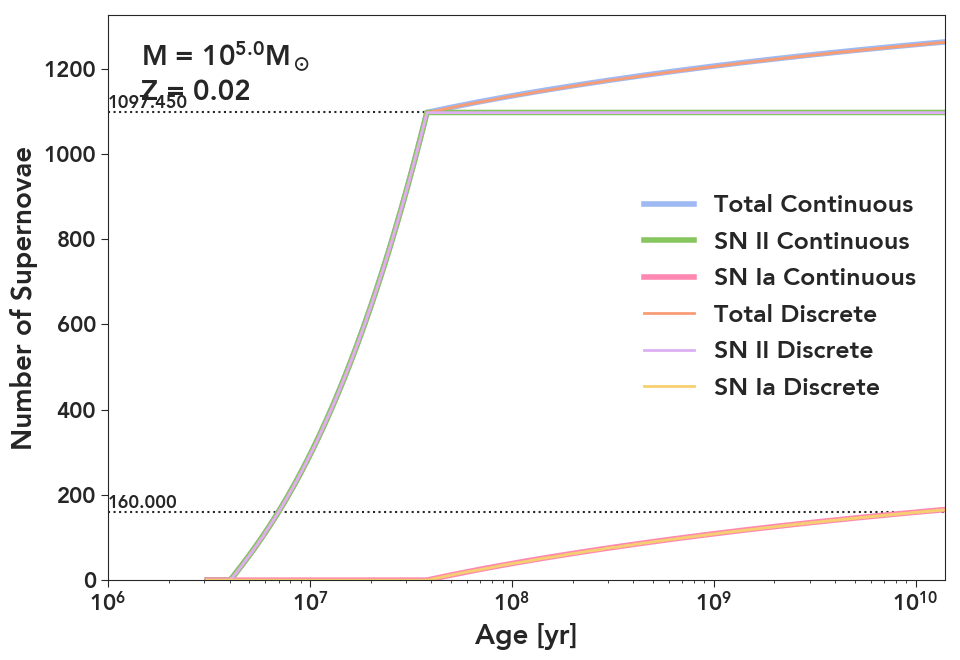

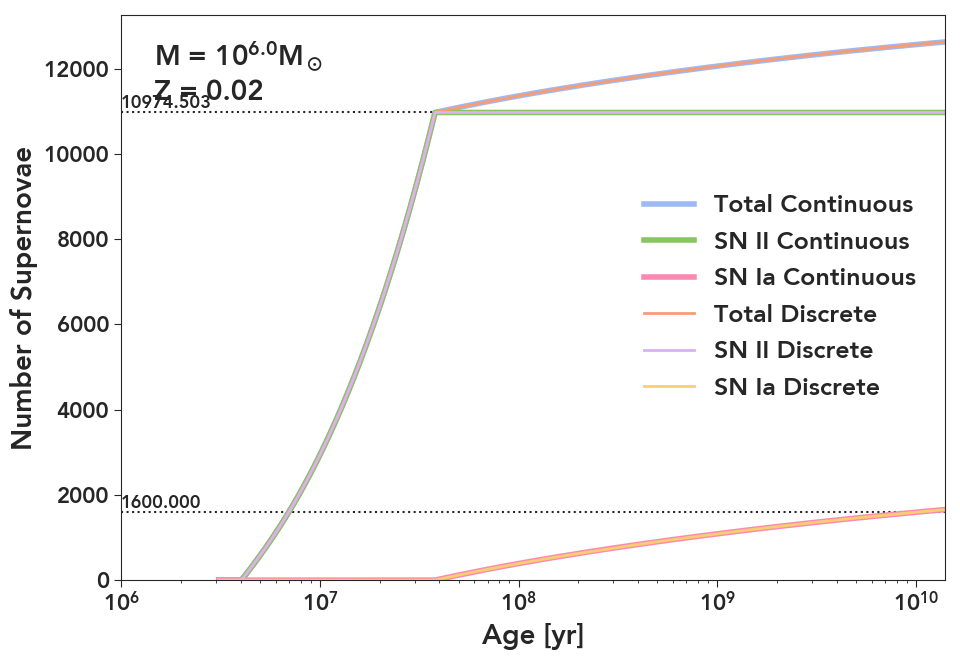

In [33]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("N_SN", m, 0.02)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


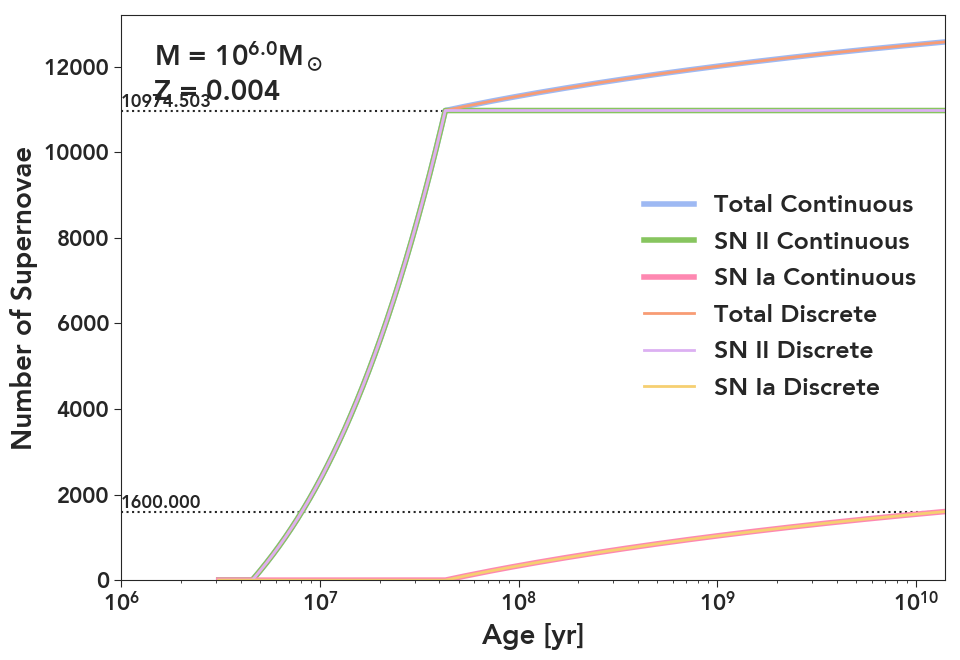

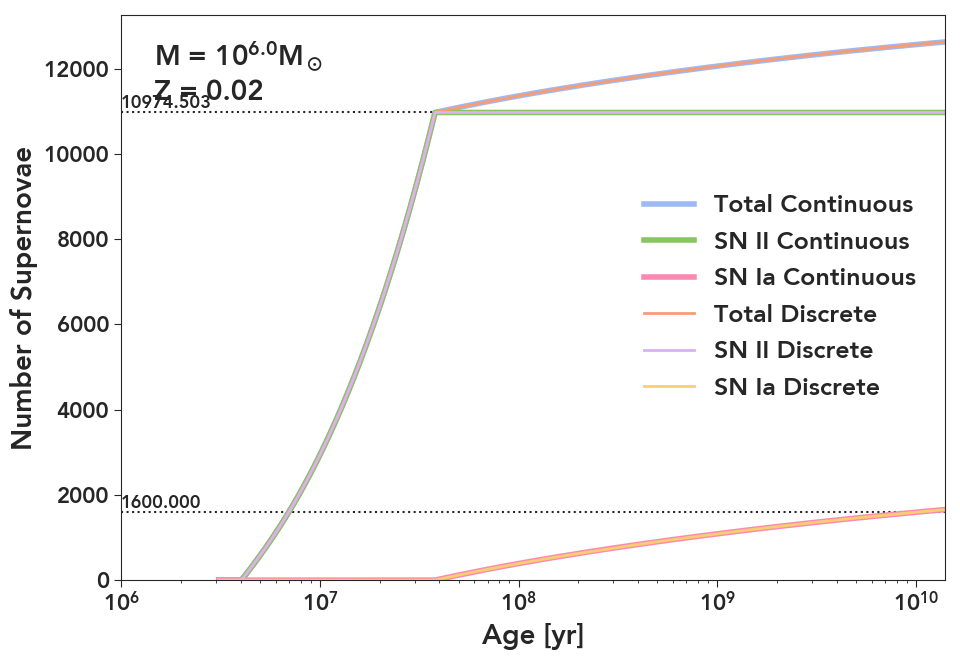

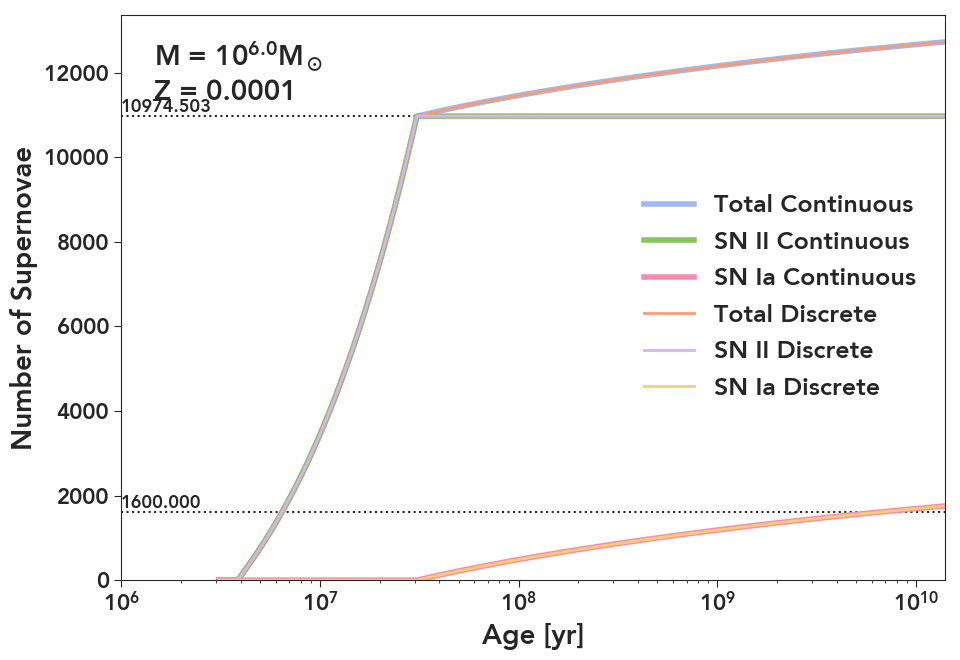

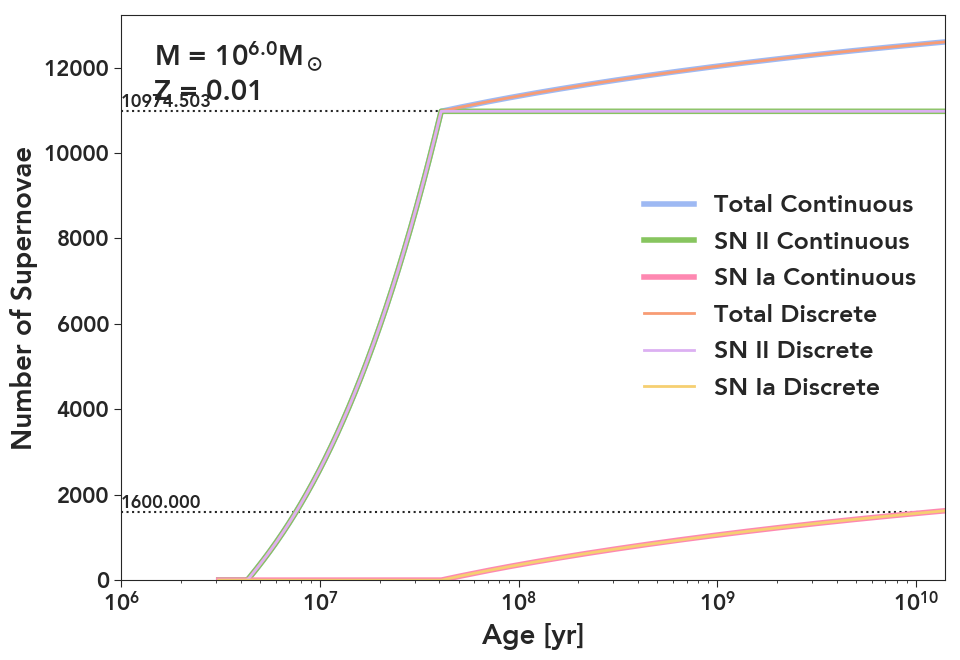

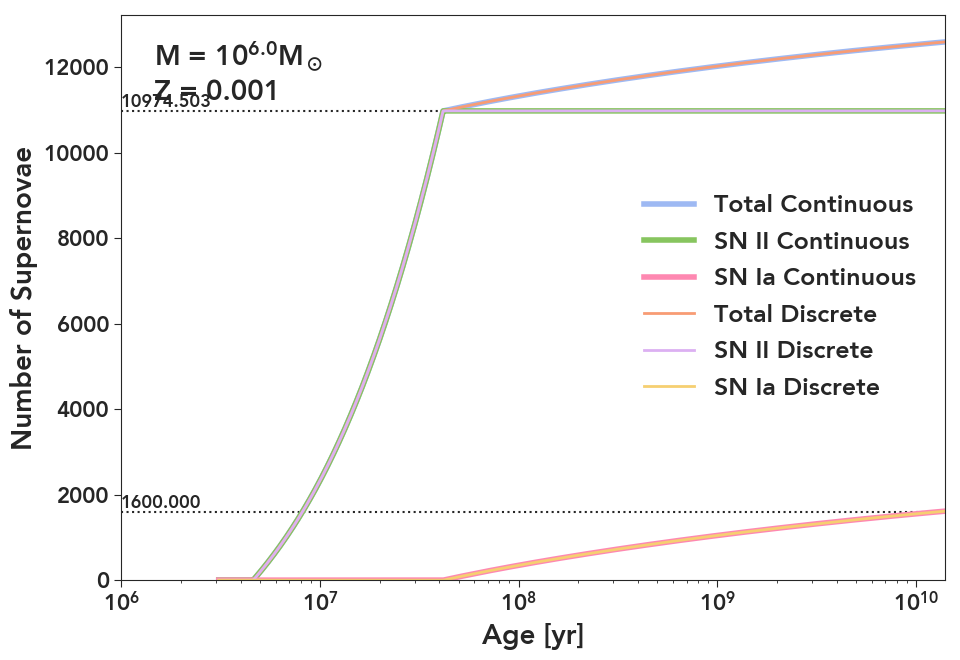

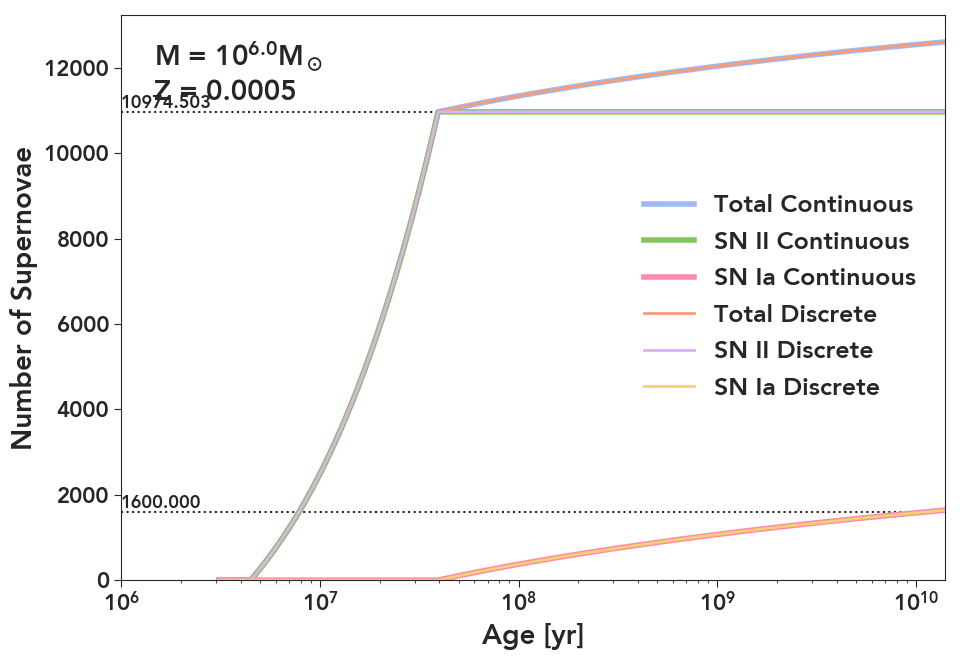

In [34]:
for z in times:
    plot_history("N_SN", 1E6, z)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


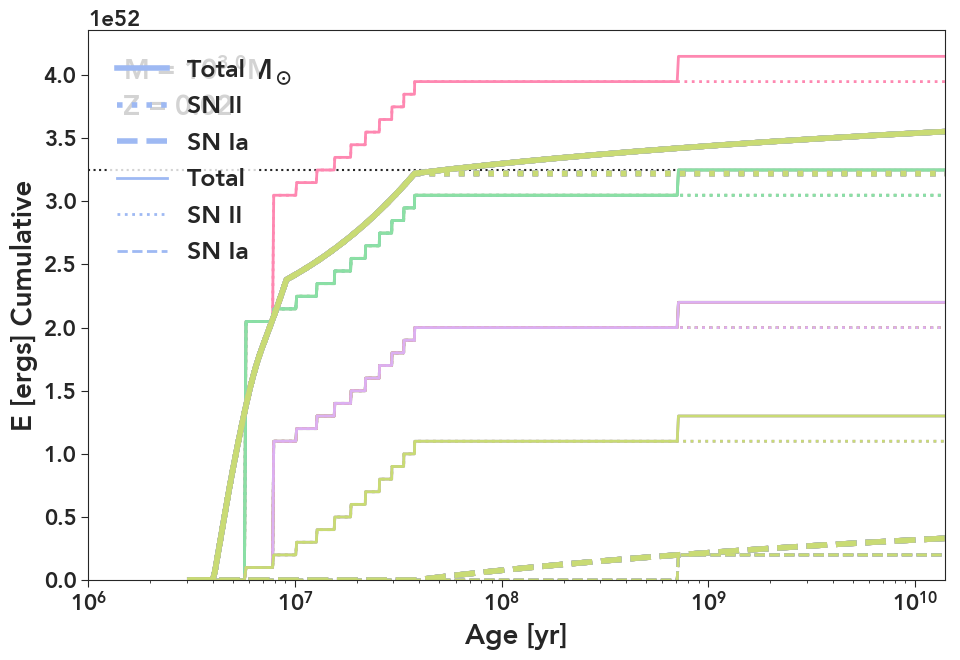

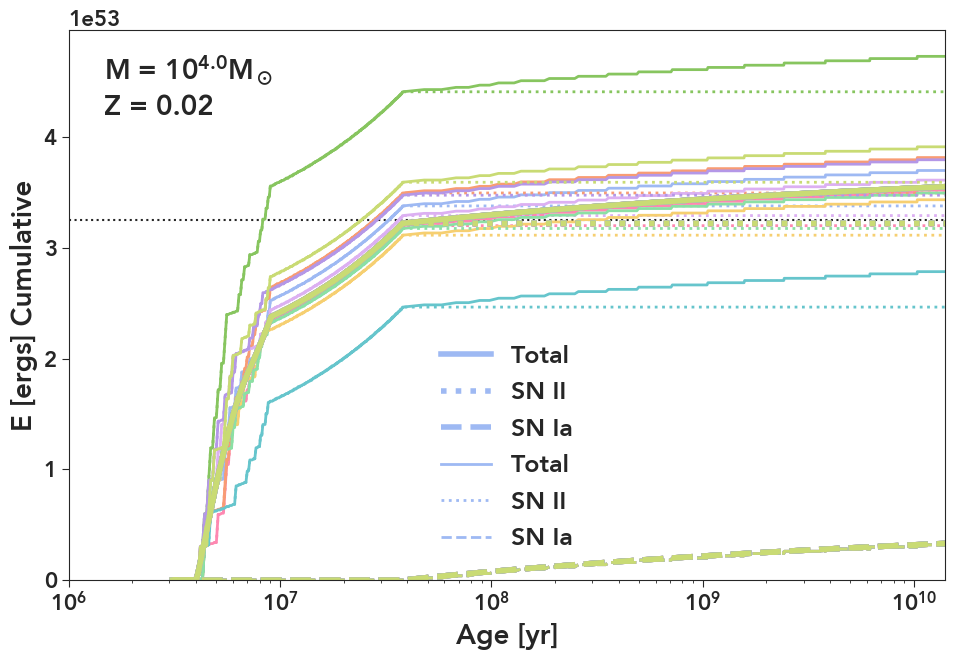

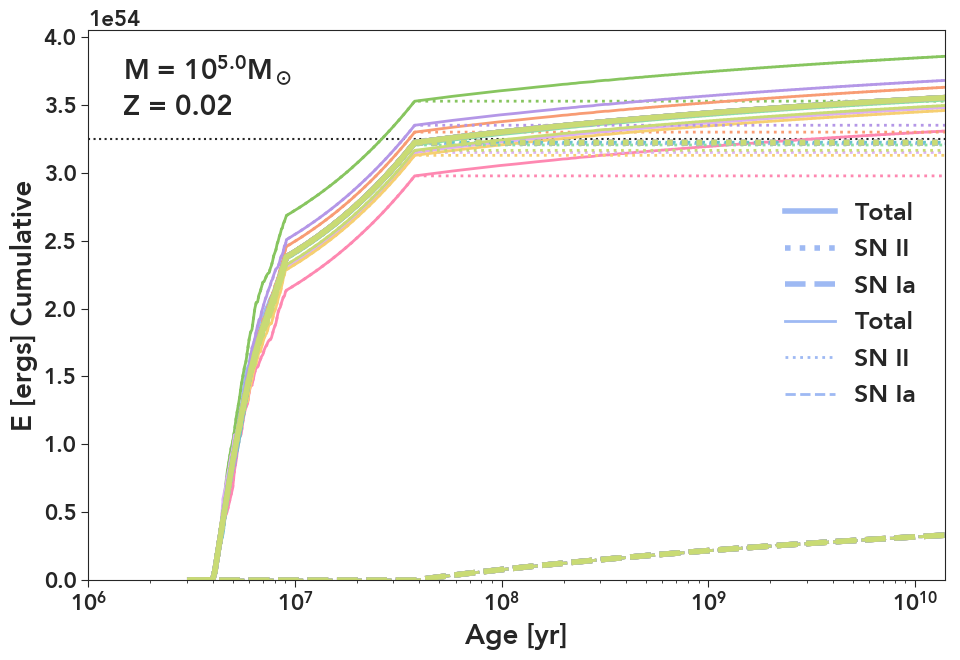

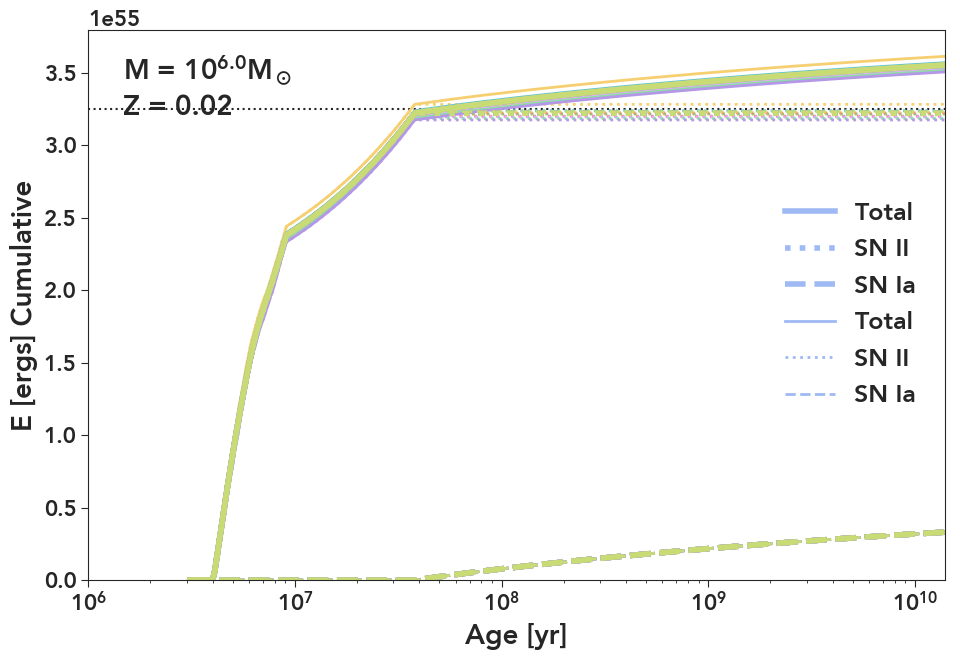

In [35]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history_energy(m, 0.02, 10)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


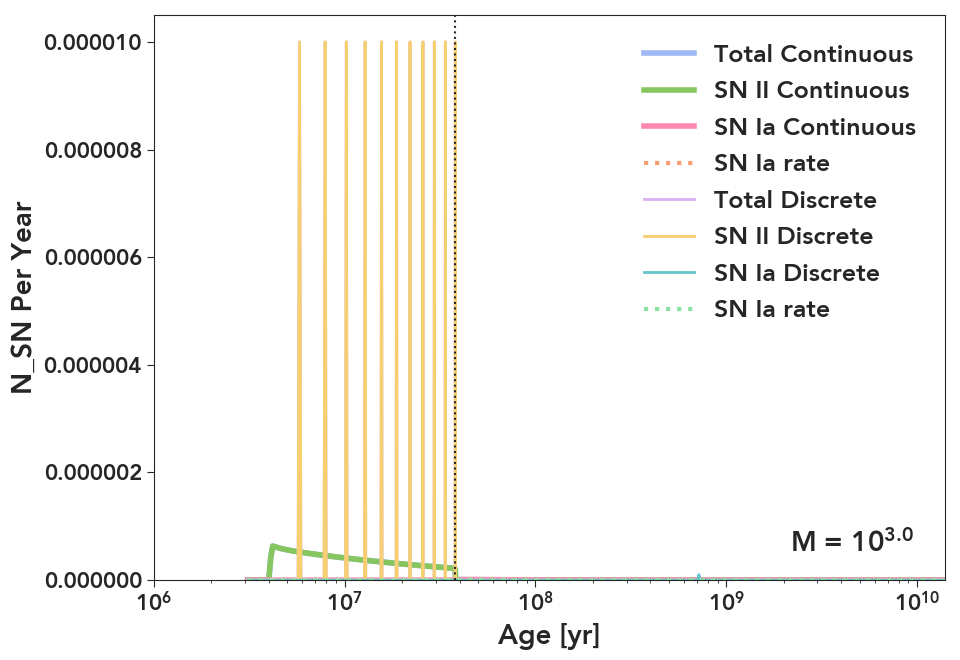

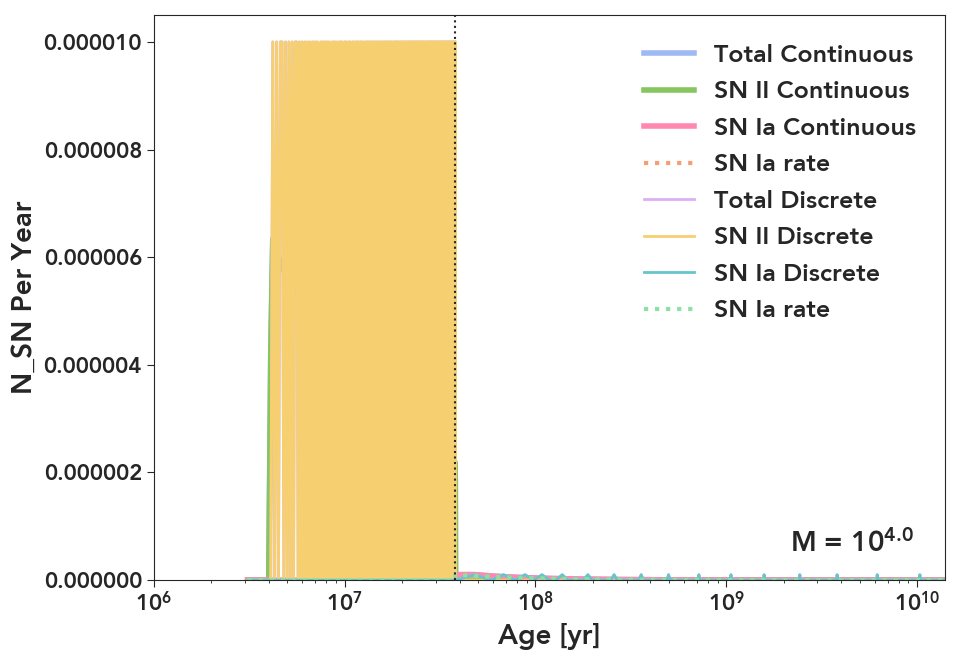

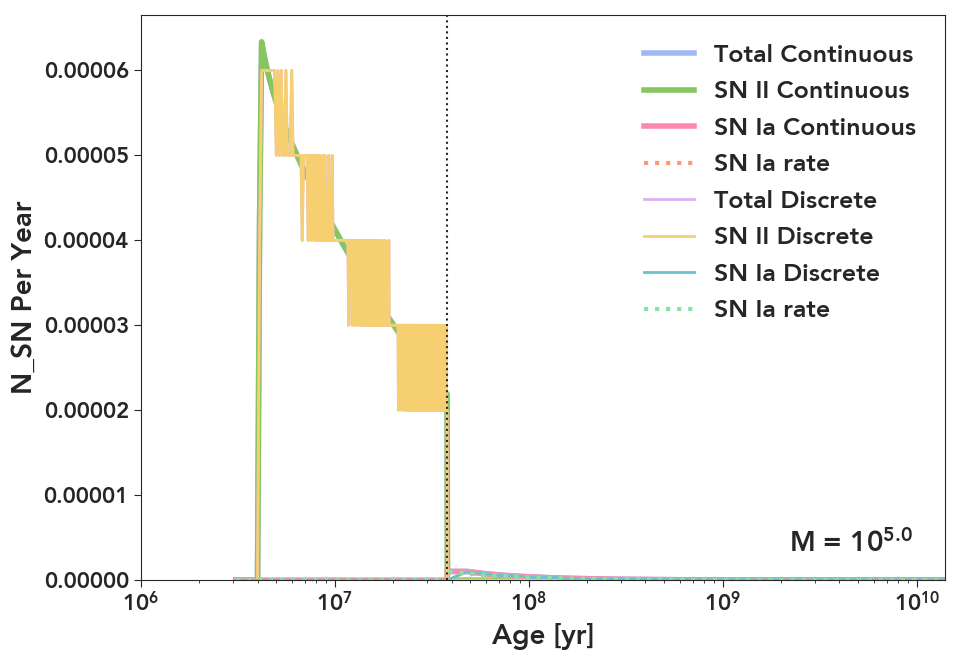

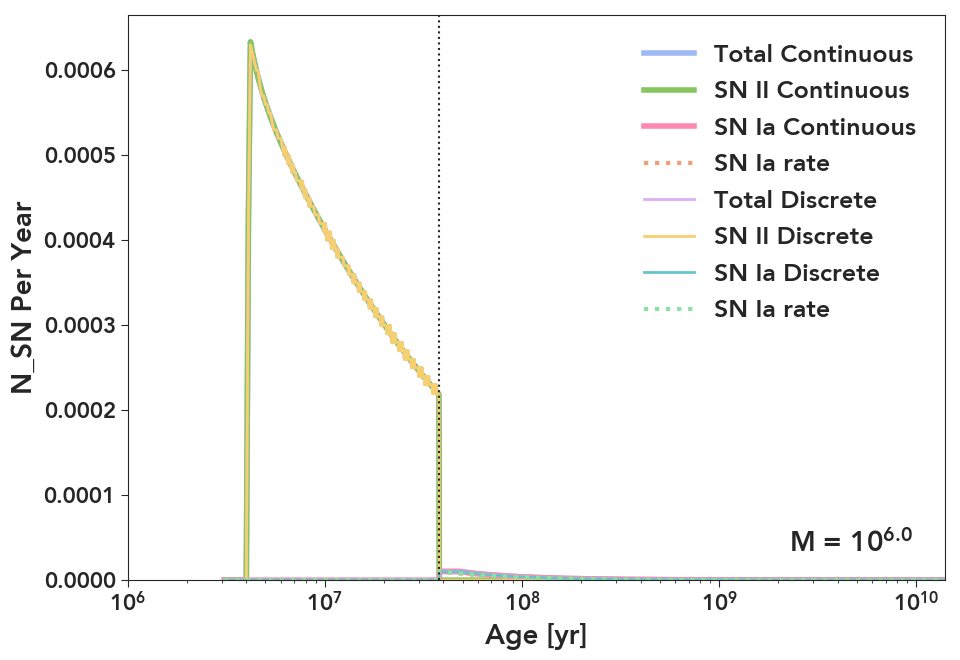

In [36]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_rates("N_SN", m, 0.02)

In [37]:
# for m in [1E3, 1E4, 1E5, 1E6]:
#     plot_rates("E", m, 10)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


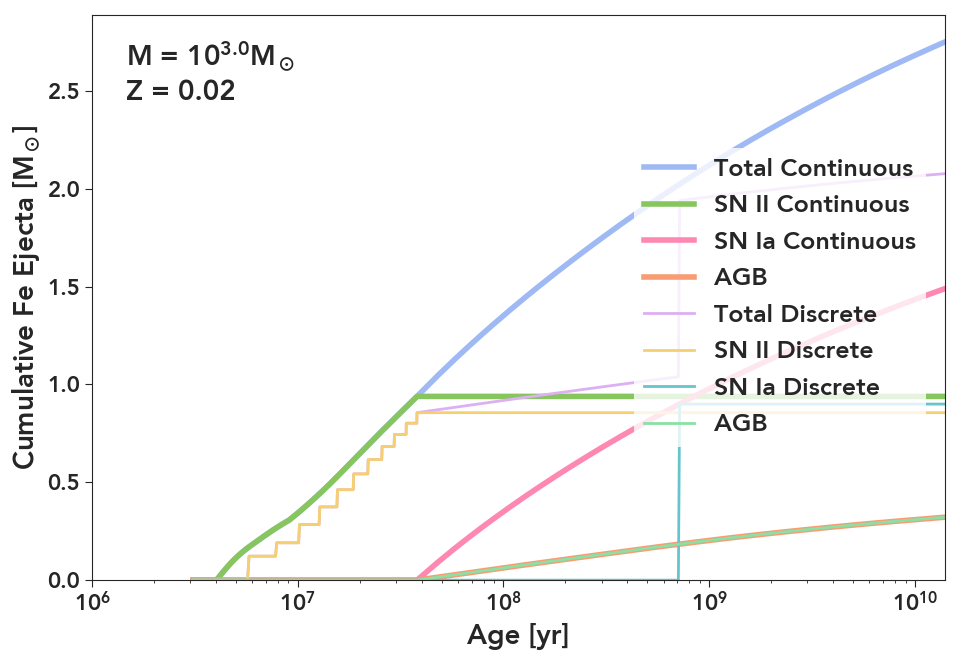

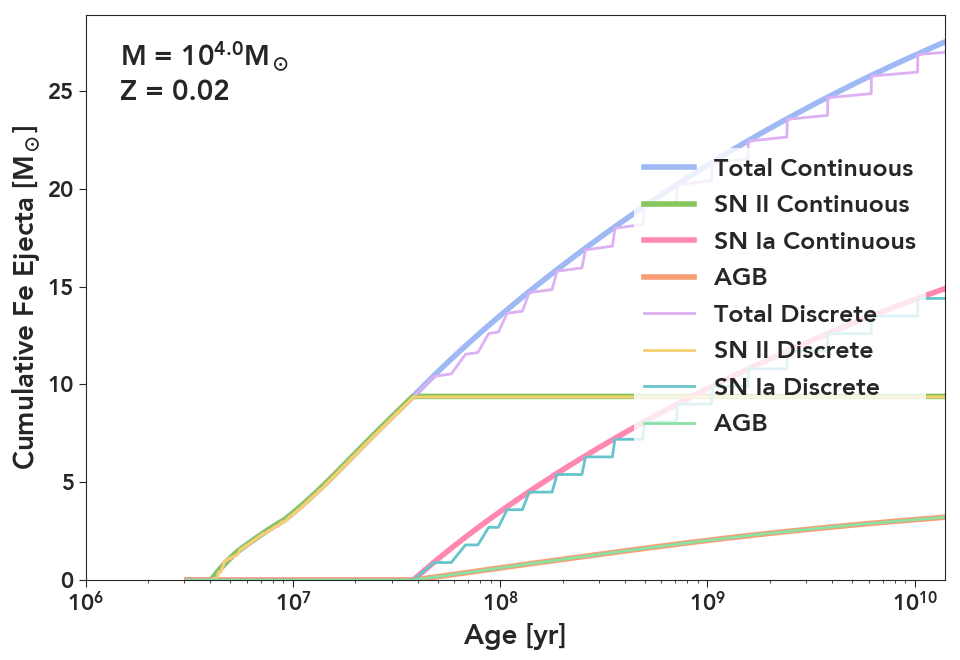

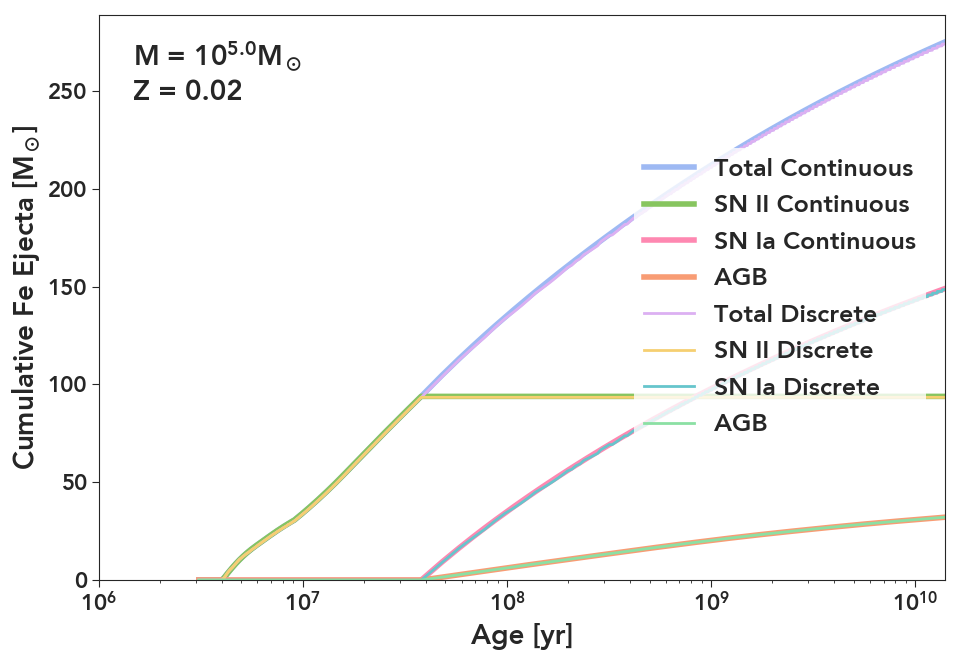

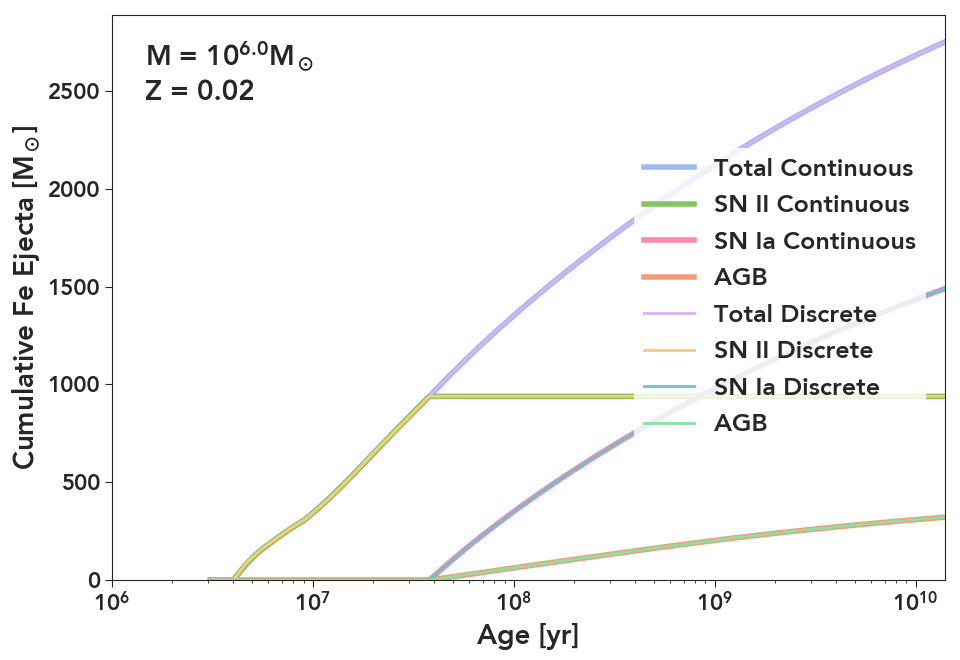

In [38]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("Fe", m, 0.02)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


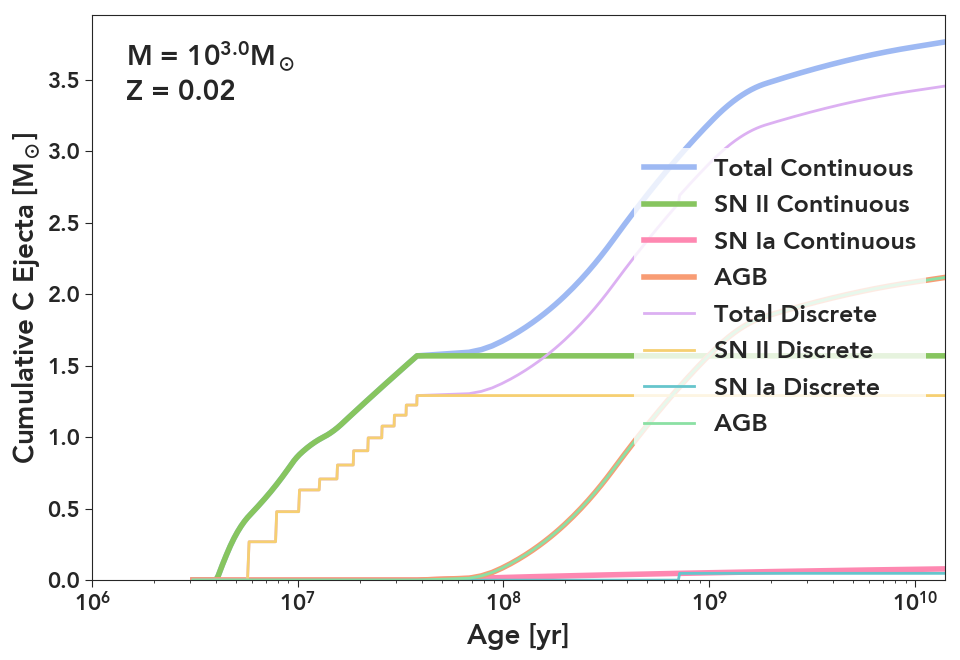

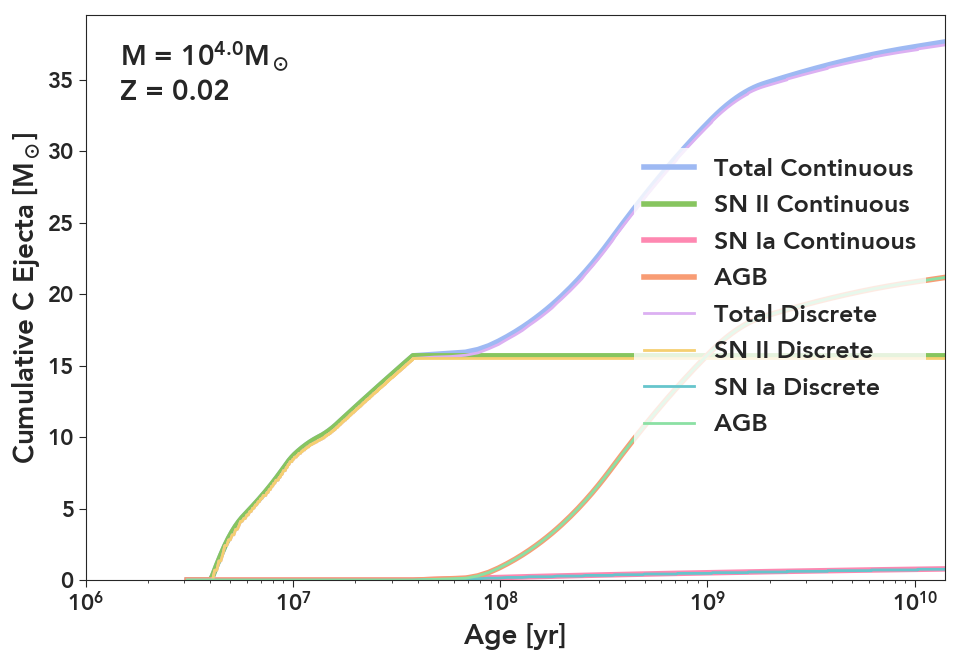

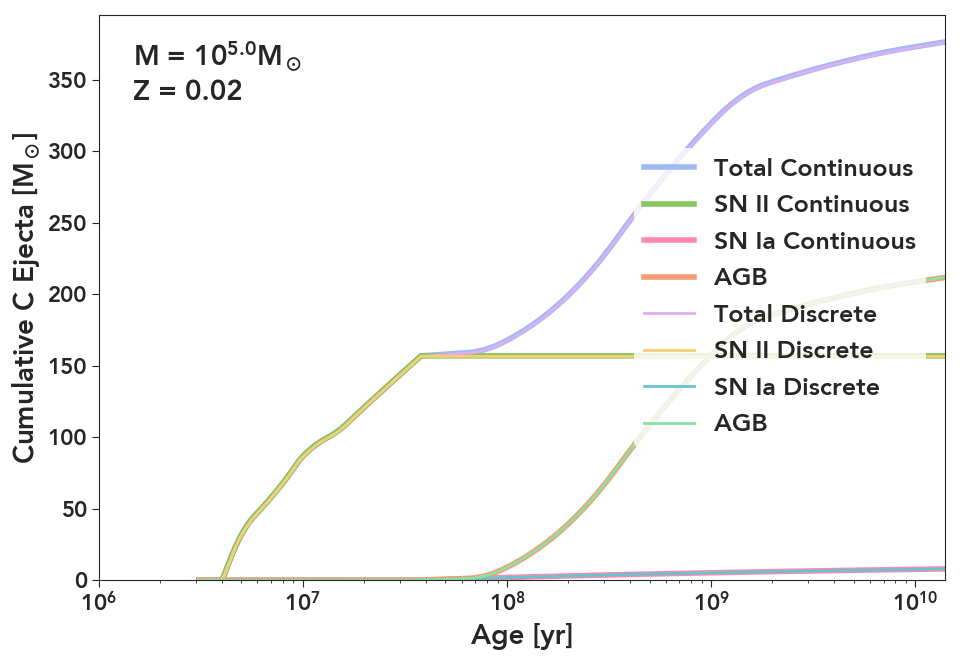

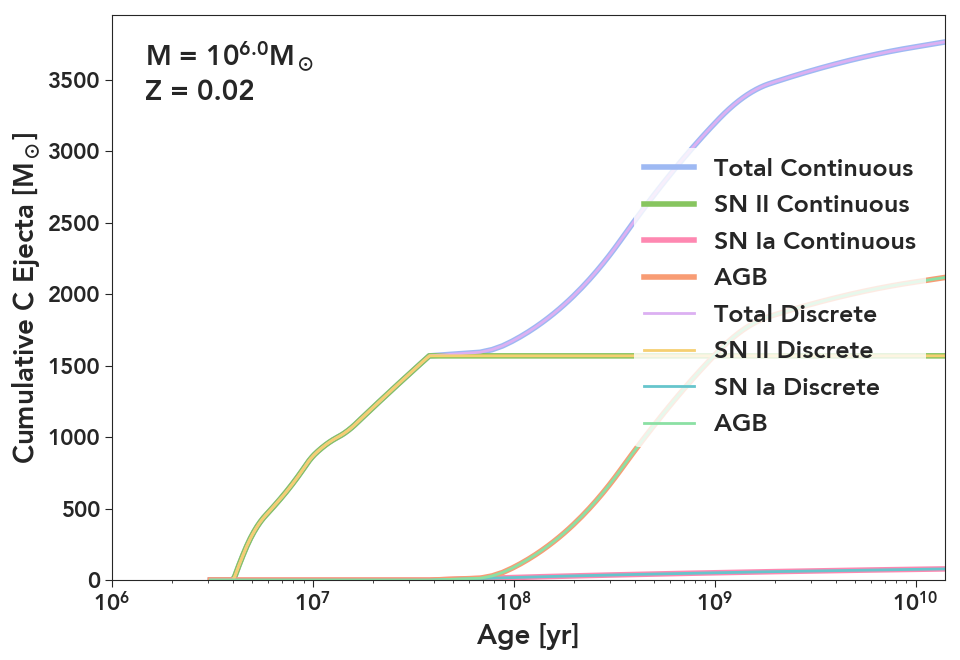

In [39]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("C", m, 0.02)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


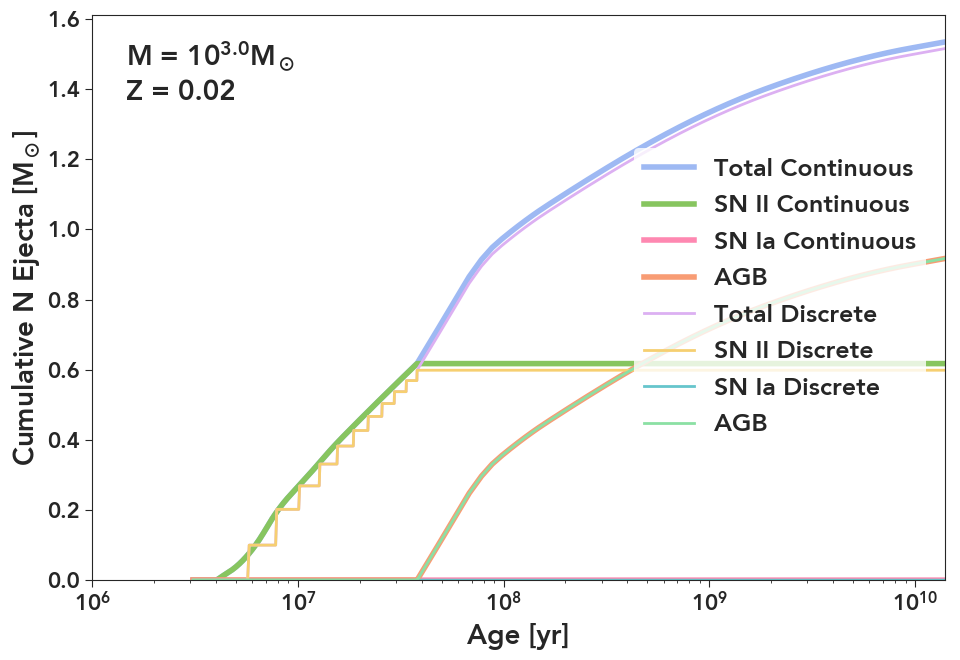

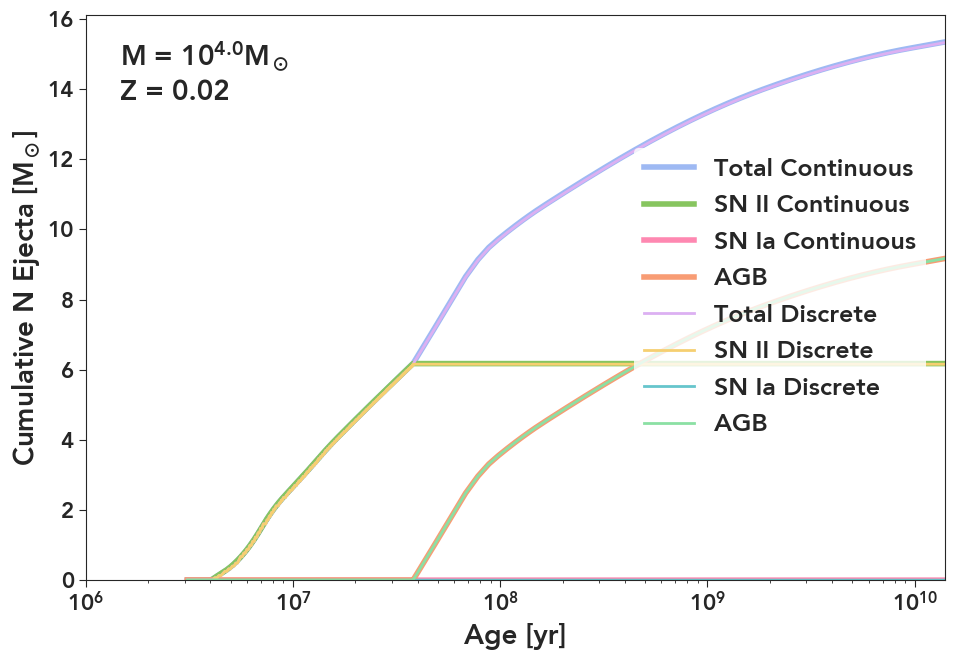

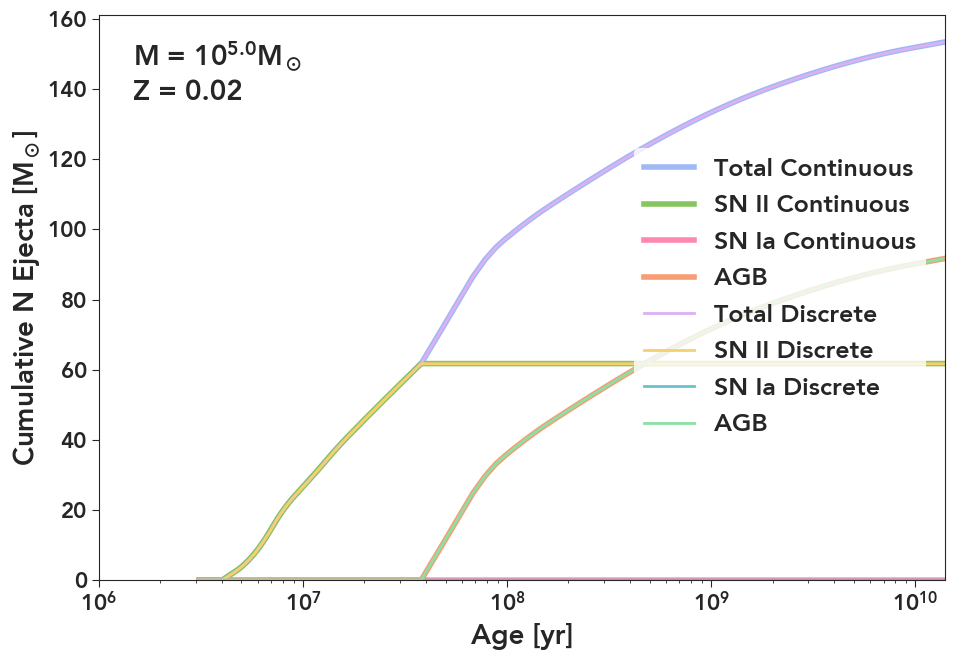

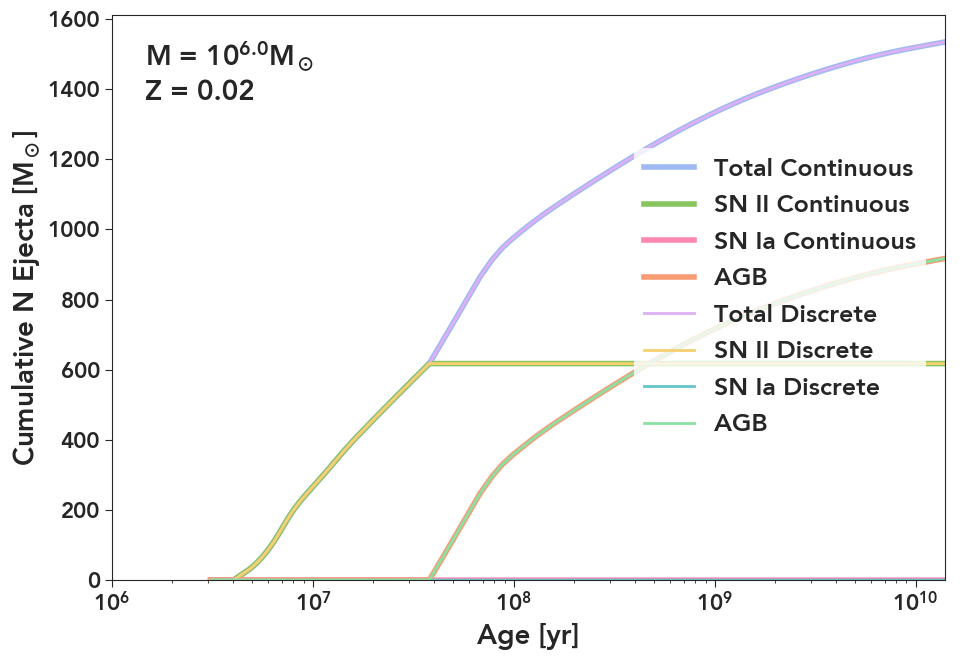

In [40]:
for m in [1E3, 1E4, 1E5, 1E6]:
    plot_history("N", m, 0.02)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


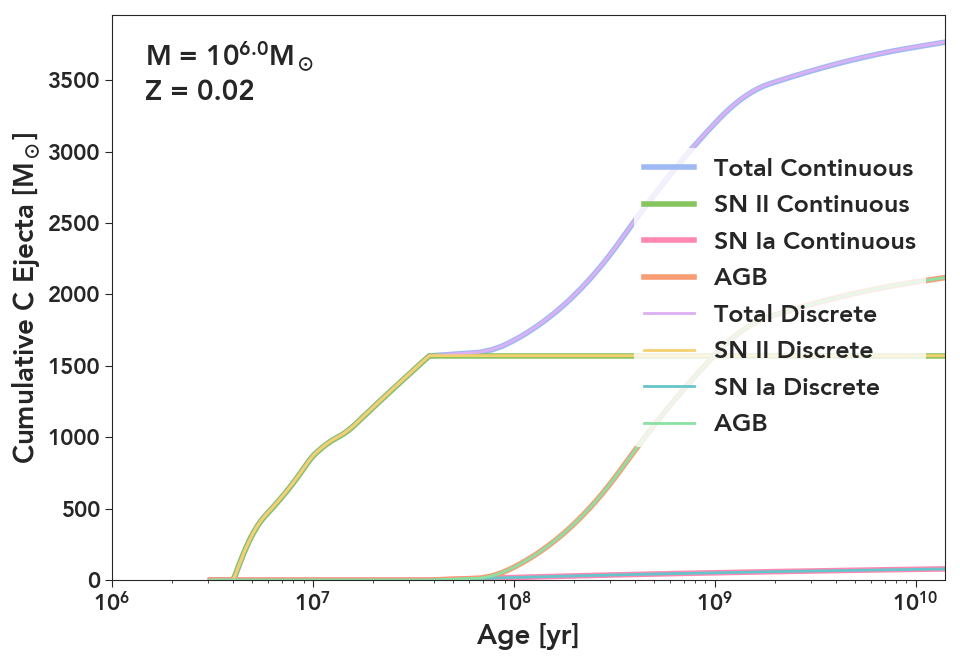

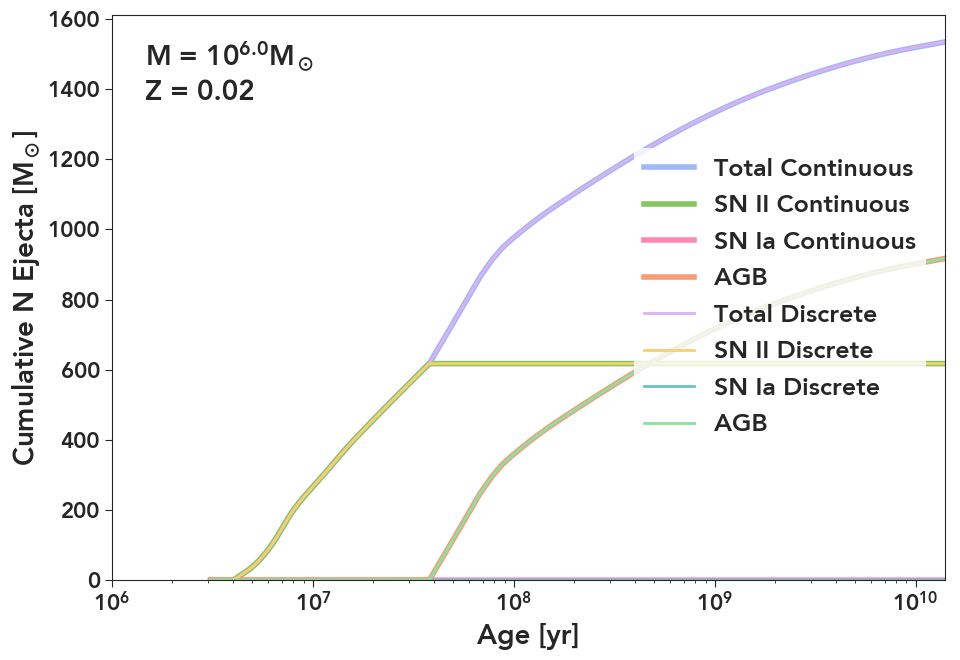

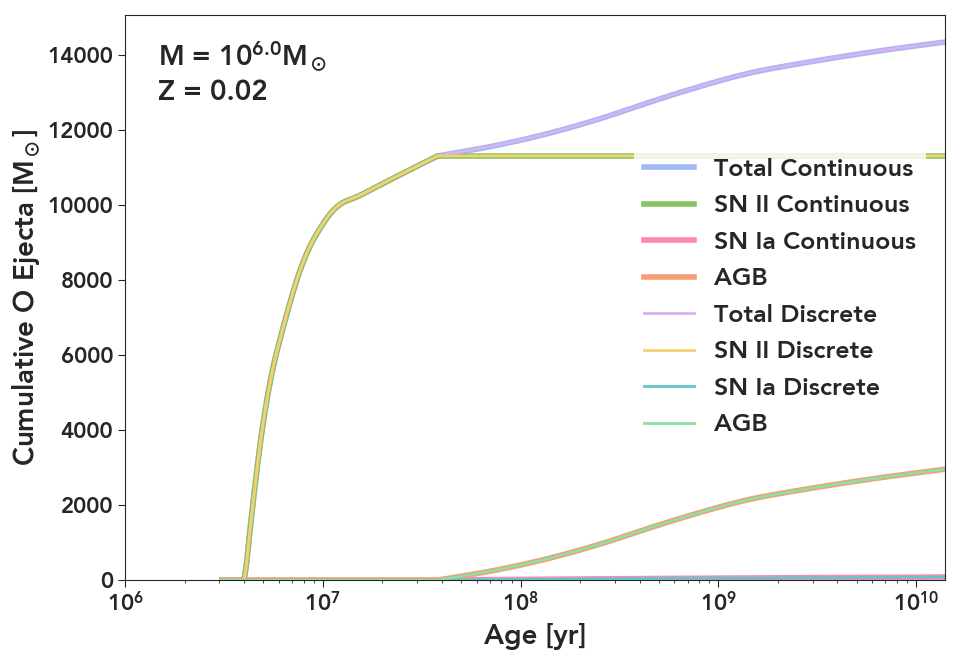

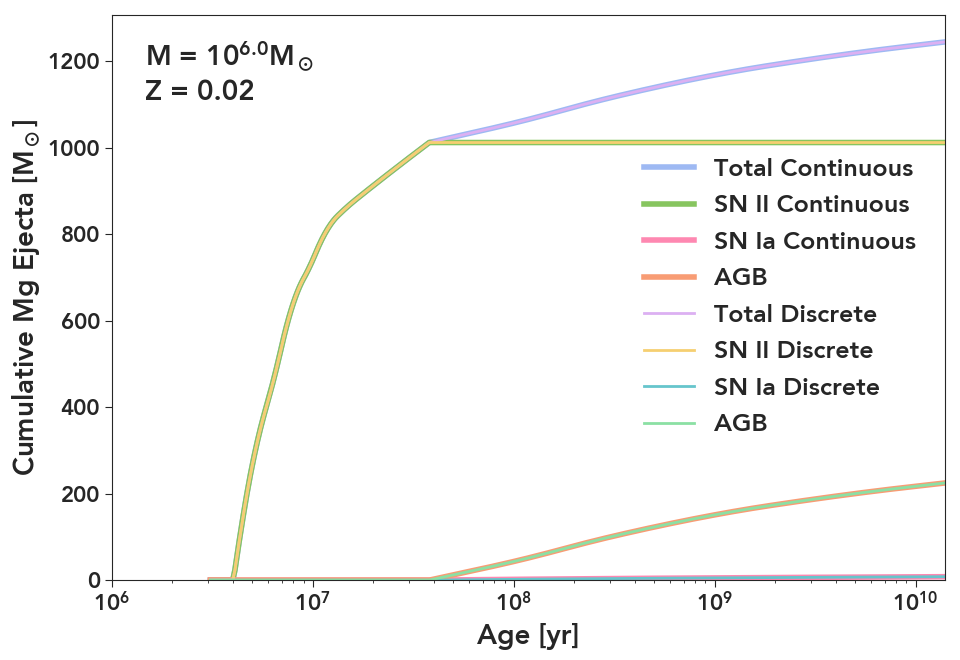

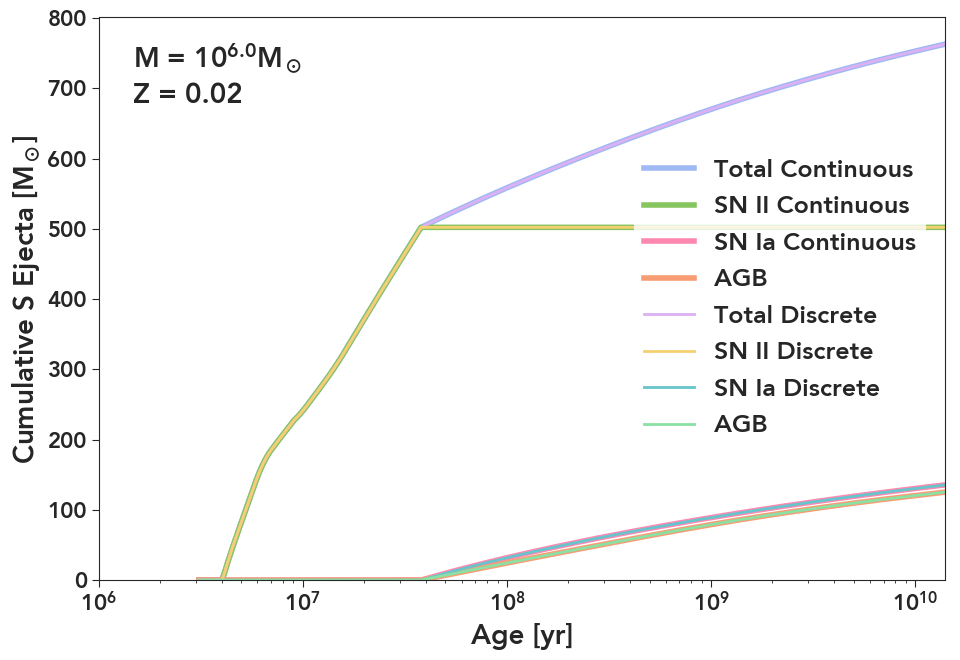

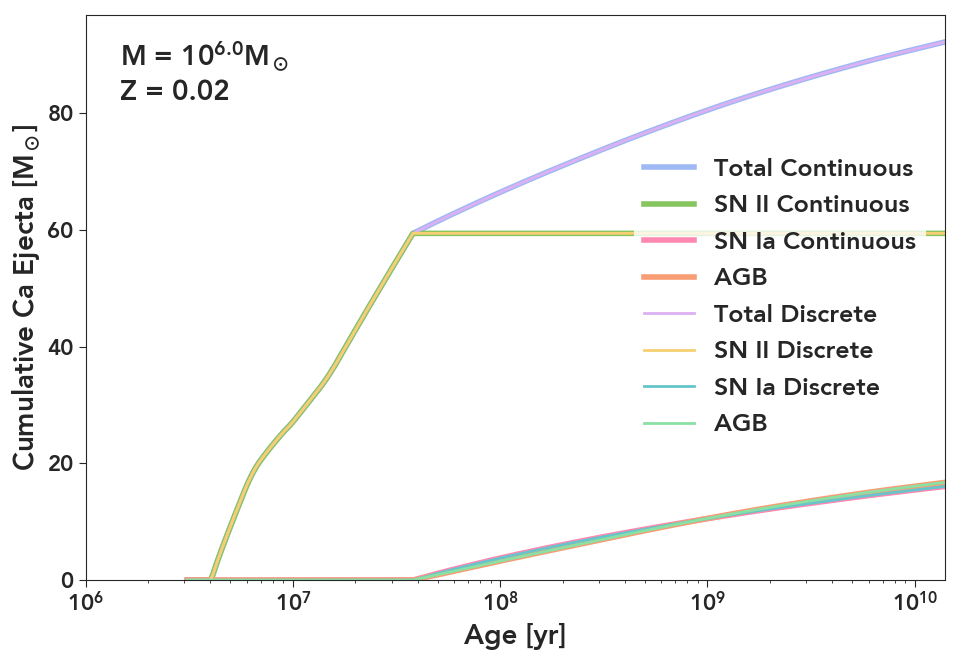

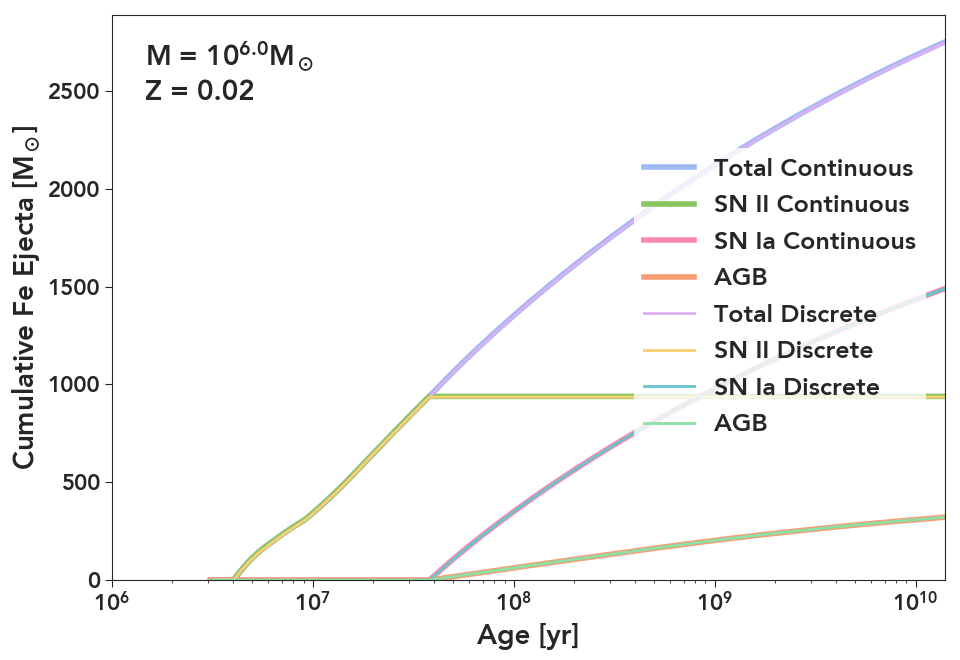

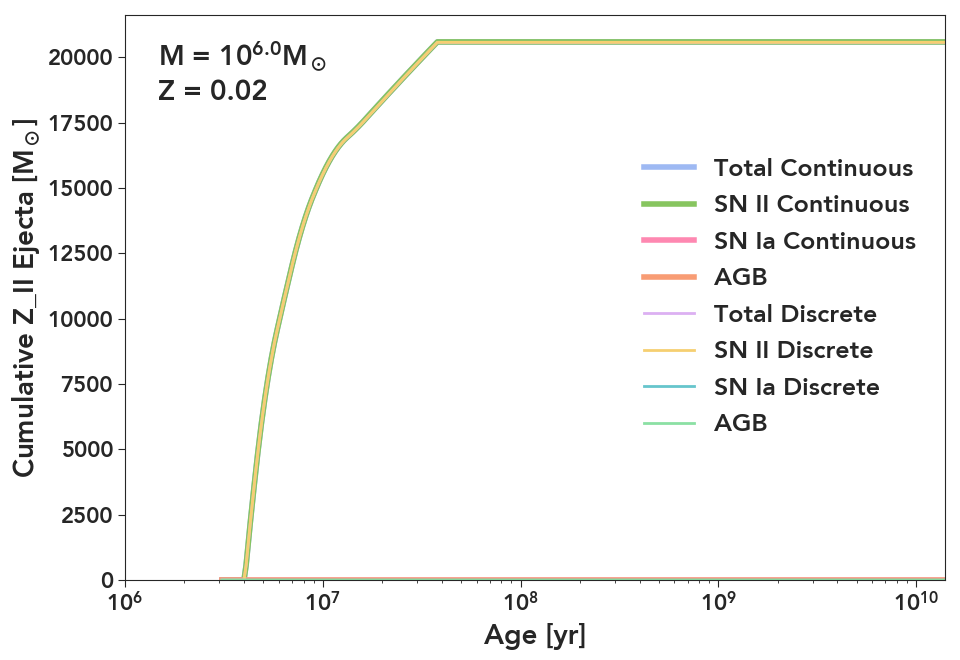

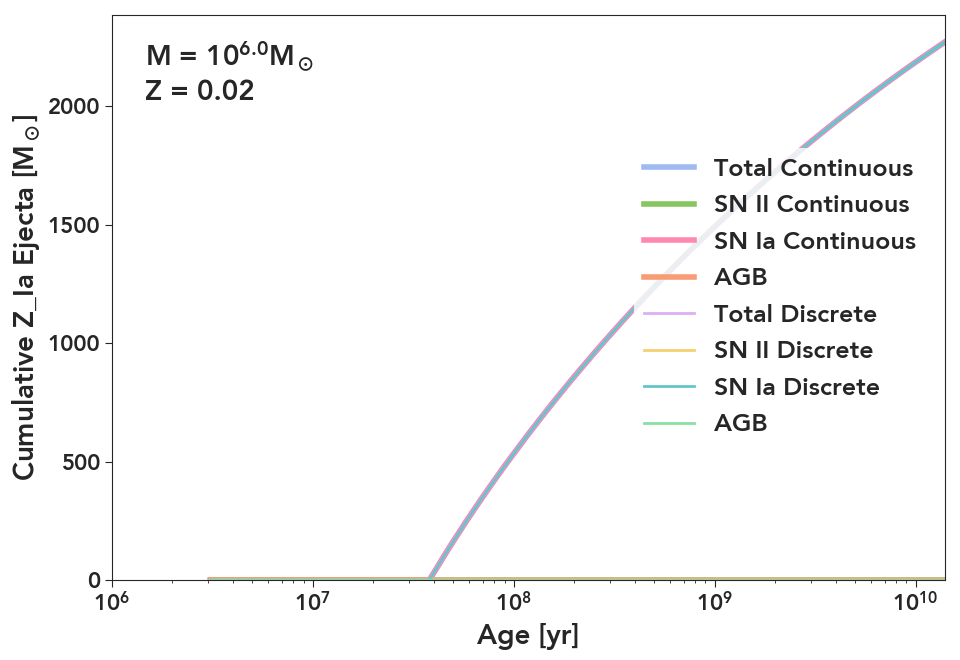

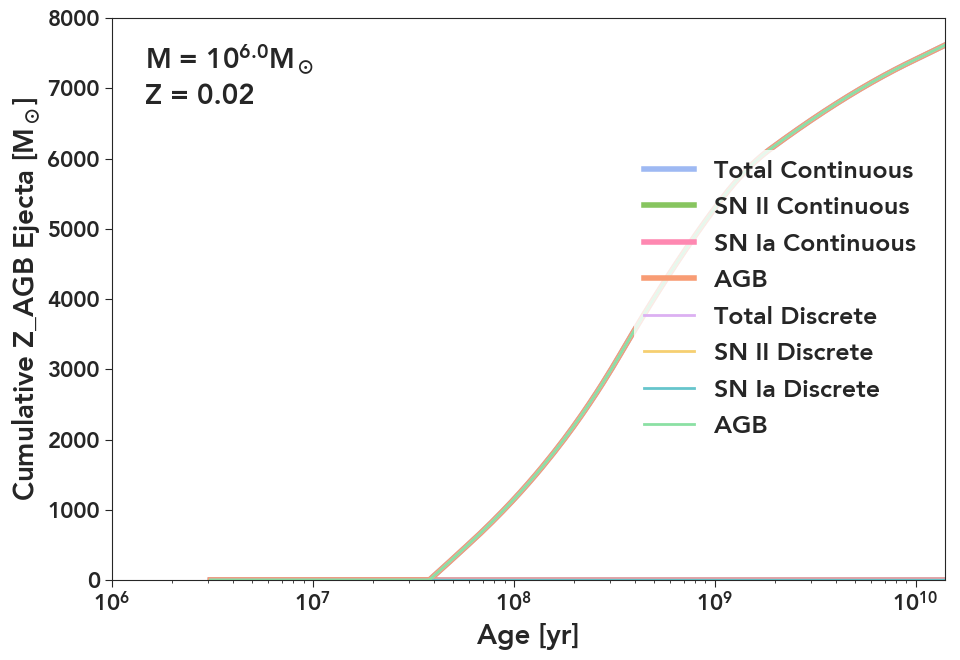

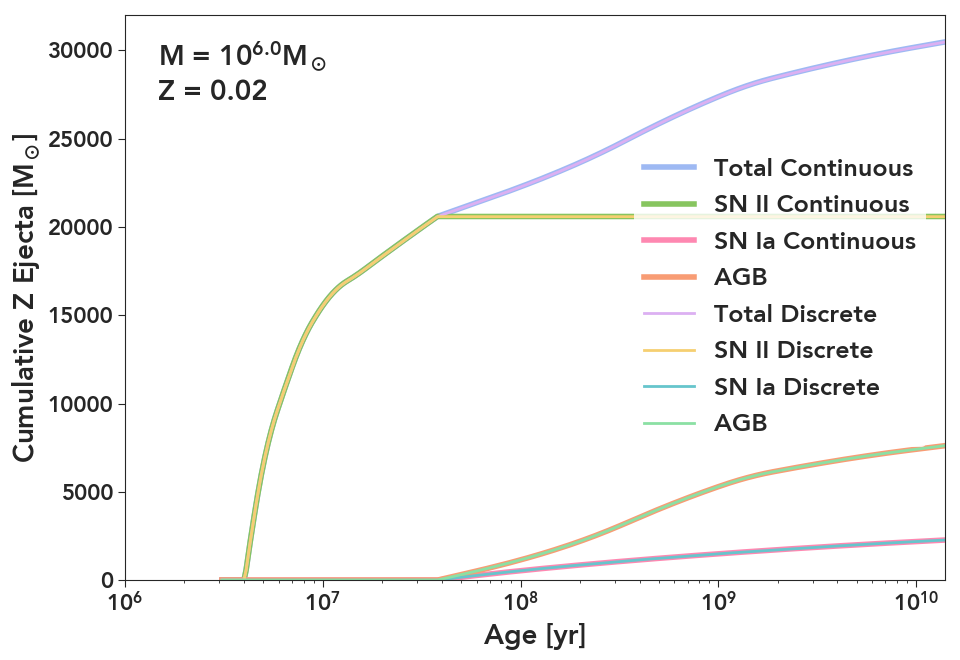

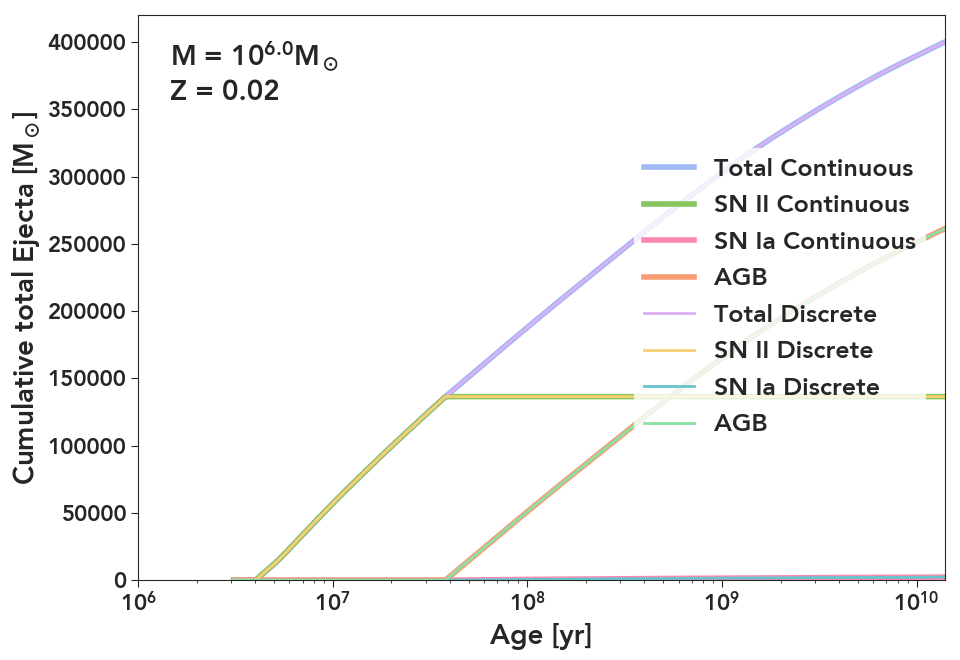

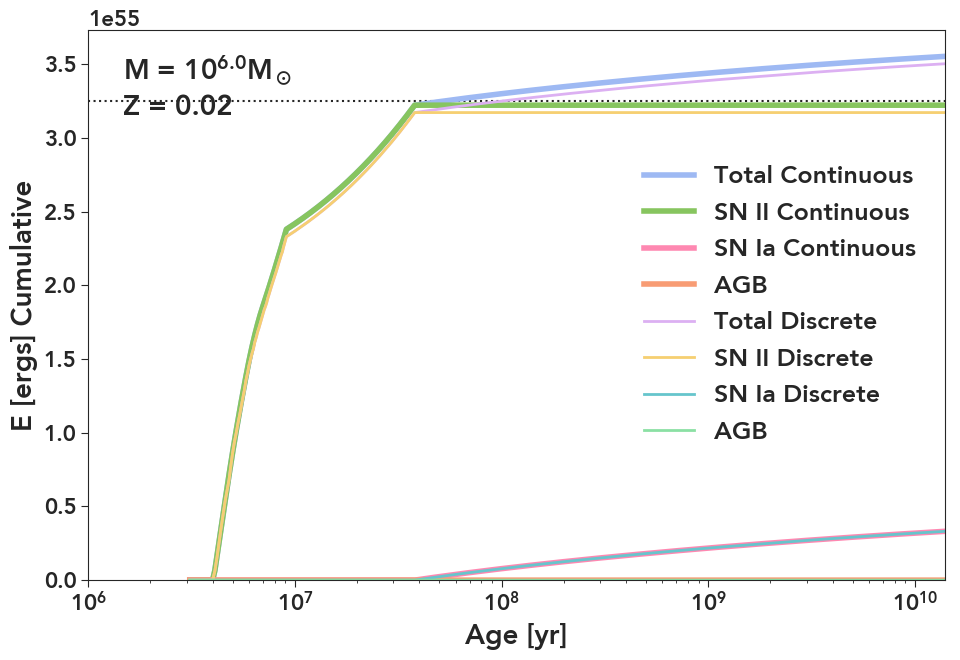

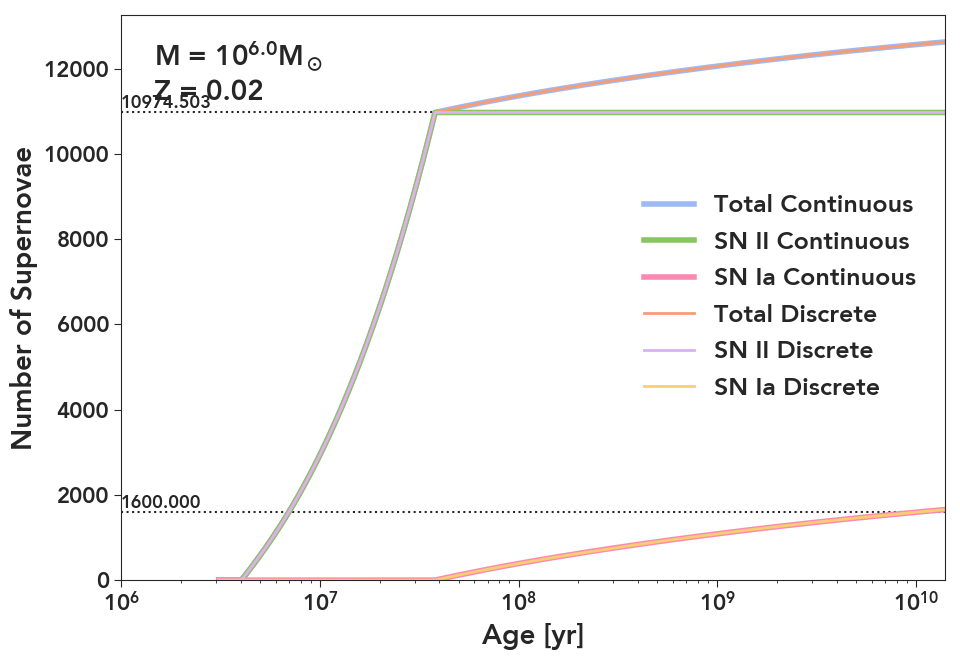

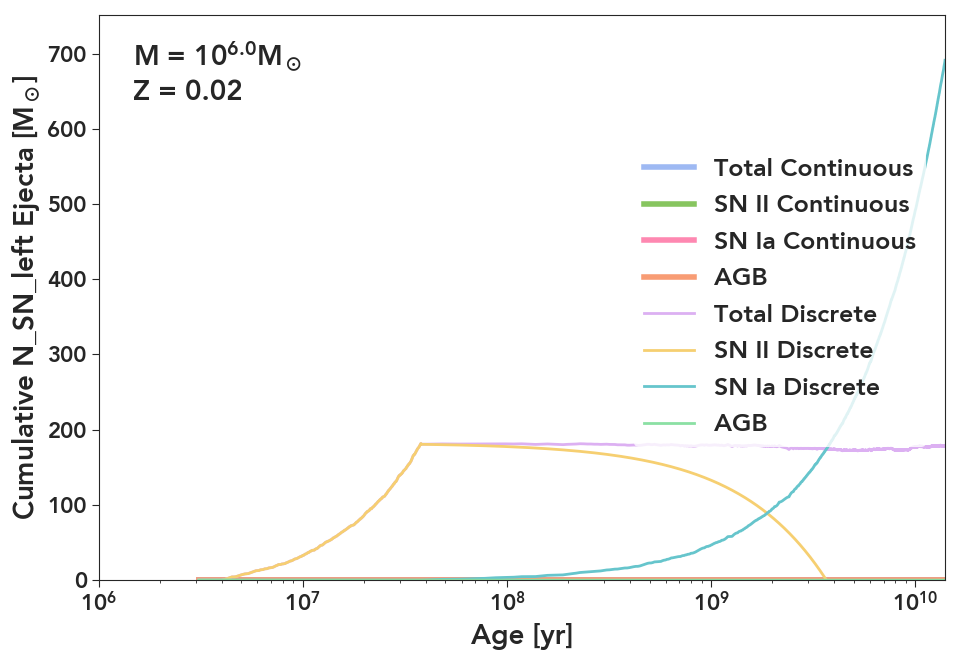

In [41]:
for elt in all_fields:
    plot_history(elt, 1E6, 0.02)

In [42]:
from matplotlib import colors
from matplotlib import cm

In [43]:
def yield_agb_wrapper(z, m, elt):
    if elt == "Z":
        raw_z_yield = core.get_yields_raw_agb_py(z, m)[agb_idxs_yields["Z_AGB"]]
        ca_yield = yield_agb_wrapper(z, m, "Ca")
        s_yield = yield_agb_wrapper(z, m, "S")
        fe_yield = yield_agb_wrapper(z, m, "Fe")
        return raw_z_yield + ca_yield + s_yield + fe_yield
    
    # implicit else
    if elt in ["S", "Ca", "Fe"]:
        return (z / 0.02) * solar_metallicities[elt] * core.get_yields_raw_agb_py(z, m)[agb_idxs_yields["total"]]
    
    # implicit else
    return core.get_yields_raw_agb_py(z, m)[agb_idxs_yields[elt]]

In [44]:
norm = colors.LogNorm(vmin=1E-4, vmax=0.02)
mappable = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
mappable.set_array([])

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


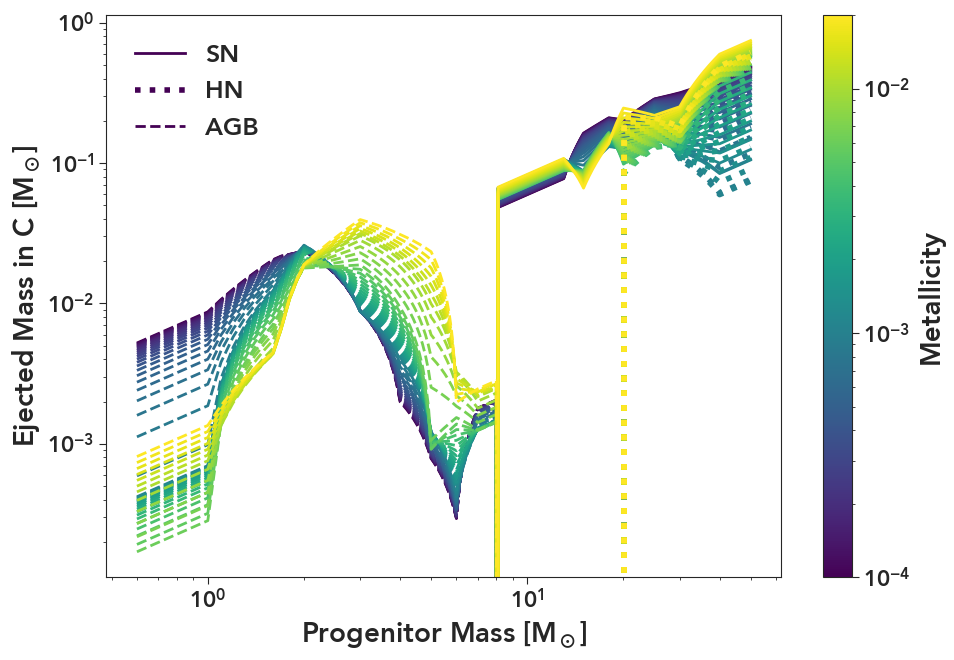

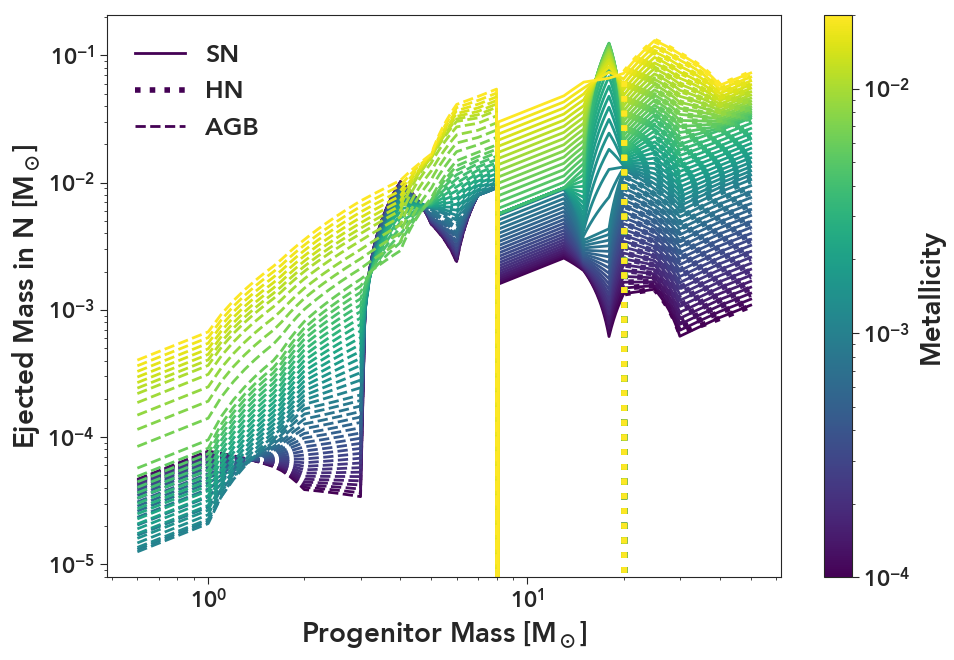

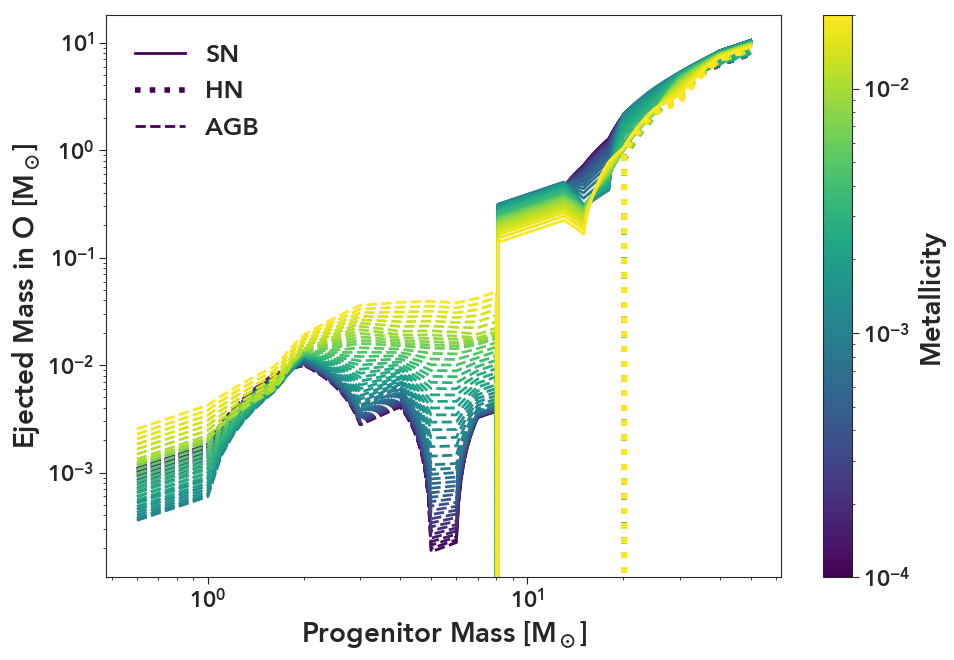

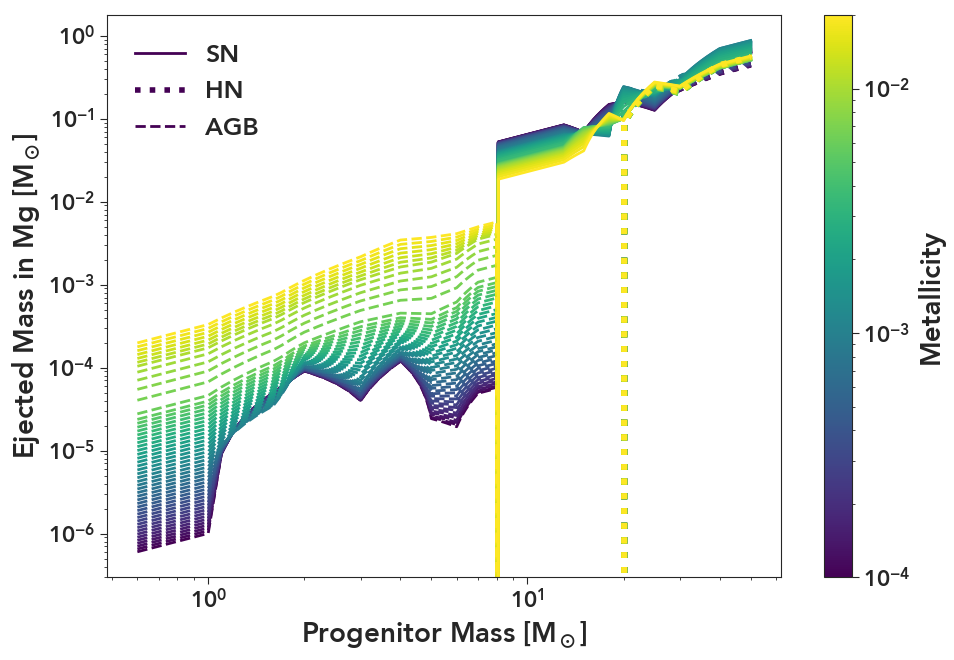

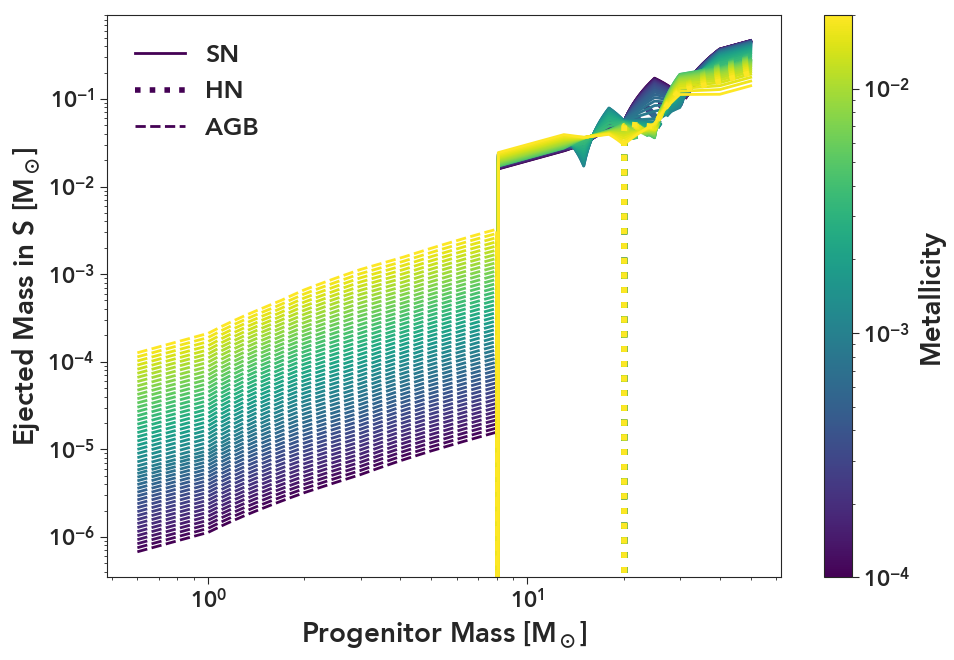

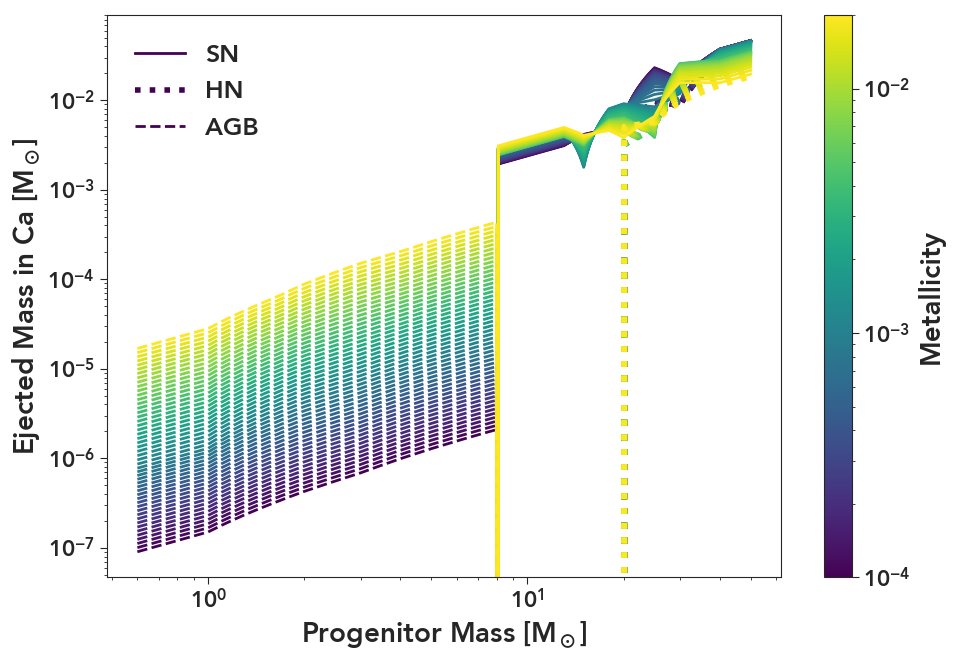

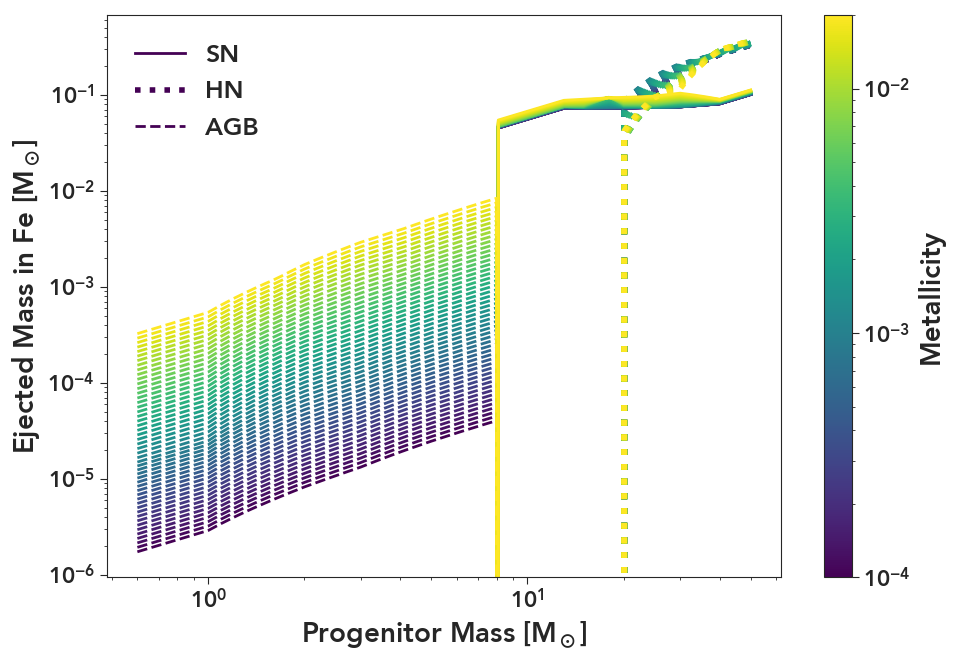

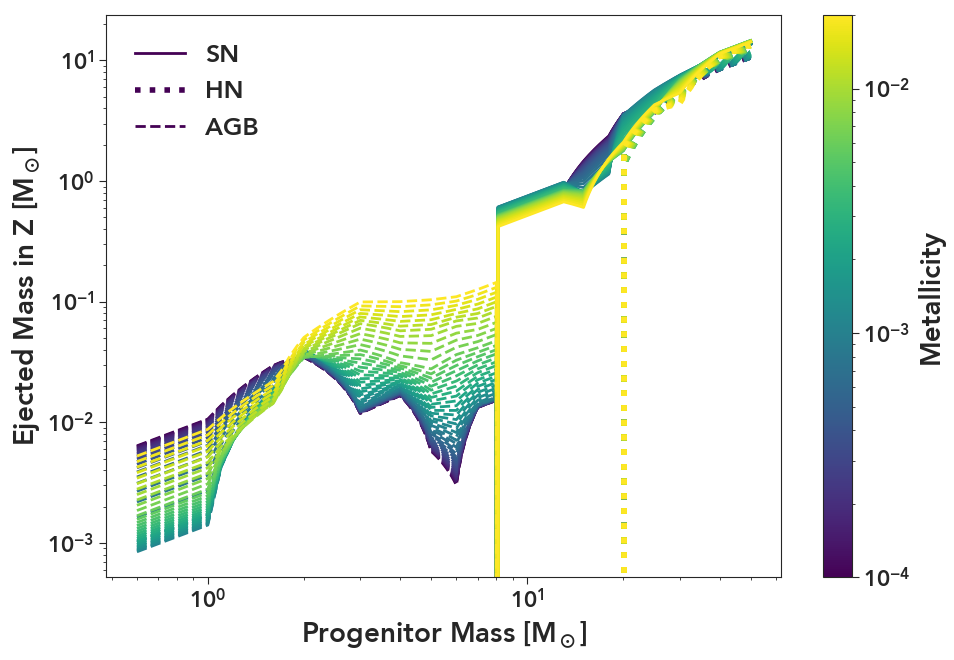

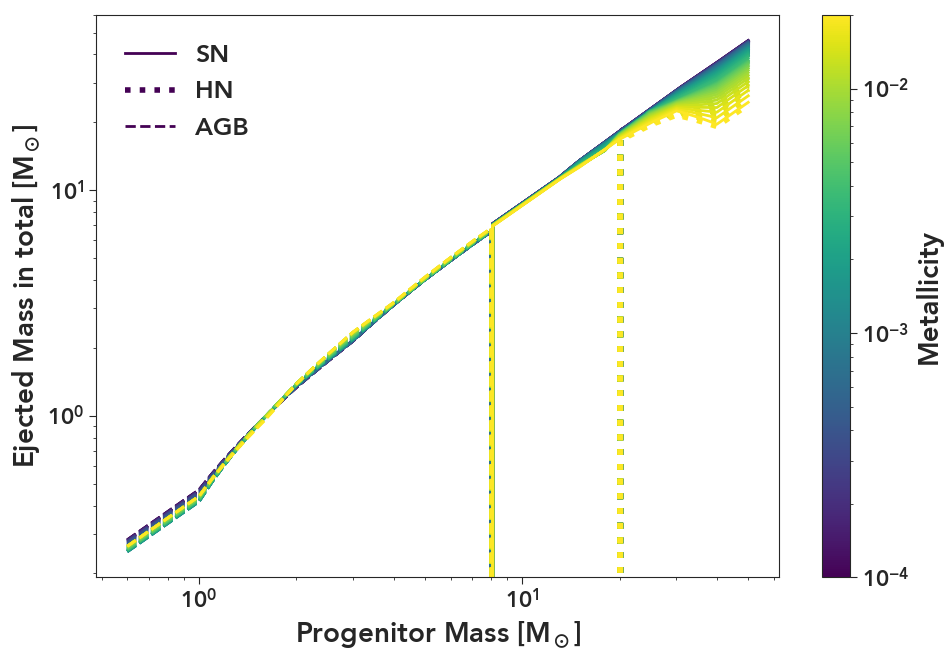

In [45]:
ls = {"AGB": "--", "SN": "-", "HN":":"}
lw = {"AGB": 2, "SN": 2, "HN":4}

ms = np.arange(0.6, 50.1, 0.1)
for elt in elts + ["Z", "total"]:
    fig, ax = bpl.subplots()
    ax.add_labels("Progenitor Mass [$M_\odot$]", "Ejected Mass in {}".format(elt) + " [$M_\odot$]")
    
#     for z_idx, z in enumerate([0.0001, 0.001, 0.005, 0.01, 0.02]):
    for z_idx, z in enumerate(np.logspace(-4, np.log10(0.02), 50)):
        c = mappable.to_rgba(z)
        
        for func, label in zip([core.get_yields_raw_sn_ii_py,
                                core.get_yields_raw_hn_ii_py,
                                core.get_yields_raw_agb_py], 
                                   ["SN", "HN", "AGB"]):
            if label == "AGB":
                yields = [yield_agb_wrapper(z, m, elt) for m in ms]
            else:
                yields = [func(z, m)[sn_ii_idxs[elt]] for m in ms]



            if z_idx > 0:
                plot_label=None
            else:
                plot_label=label
            ax.plot(ms, yields, label=plot_label, ls=ls[label], lw=lw[label], c=c)
    
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    cbar = fig.colorbar(mappable)
    cbar.set_label("Metallicity")
    ax.legend()

# SN rates

In [46]:
rates = [snia_discrete_elts.get_sn_ia_rate_py(t, lt.lifetime(8.0, 0.02)) for t in times[0.02]]

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


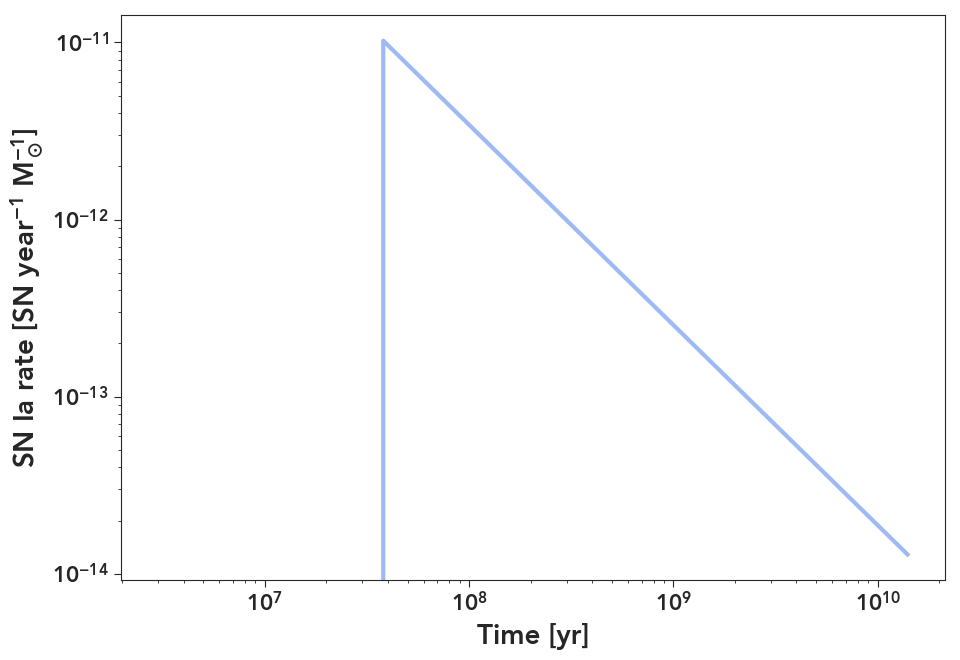

In [47]:
fig, ax = bpl.subplots()
ax.plot(times[0.02], rates)
ax.set_xscale("log")
ax.set_yscale("log")
ax.add_labels("Time [yr]", "SN Ia rate [SN year$^{-1}$ M$^{-1}_\odot$]")

In [48]:
test_times = np.arange(0, 1E10, 1E3)
for func in [snia_discrete_elts.sn_ia_core_py,
             snia_discrete_no_elts.sn_ia_core_py,
             snia_continuous_elts.sn_ia_core_py,
             snia_continuous_no_elts.sn_ia_core_py]:
    for t in tqdm(test_times):
        func(0.1, t, dt_sn, 1E6, 0.02, 40E6)

In [49]:
test_times = np.arange(0, 1E10, 1E5)
for func in [snii_discrete_elts.get_ejecta_sn_ii_py,
             snii_discrete_no_elts.get_ejecta_sn_ii_py,
             snii_continuous_elts.get_ejecta_sn_ii_py,
             snii_continuous_no_elts.get_ejecta_sn_ii_py]:
    for t in tqdm(test_times):
        func(0.1, 12, 8.1, 1E6, 0.02)

In [51]:
test_times = np.arange(0, 1E10, 1E3)
for t in tqdm(test_times):
    agb_elements.get_ejecta_agb_py(34, 6, 1E6, 0.02, 1E-5, 1E-5, 1E-5)

In [ ]:
for elts in ["C", "O", "Z", "total", "N_SN"]:
    print(snii_discrete_elts.get_ejecta_sn_ii_py(0, 53, 42, 1E6, 0.02)[sn_ii_idxs[elts]])

In [ ]:
for elts in ["C", "O", "Z", "total", "N_SN"]:
    print(snii_continuous_elts.get_ejecta_sn_ii_py(0, 53, 42, 1E6, 0.02)[sn_ii_idxs[elts]])

In [ ]:
core.get_yields_raw_sn_ii_py(34, 0.02)

In [ ]:
core.get_yields_raw_sn_ii_py(0.02, 34)[0]

In [ ]:
n_sn = core.imf_integral_py(29.695113385786325, 29.79659090887414) * 297842.737699386

In [ ]:
m_sun_to_code = 0.24946558475494385 / 297842.737699386

In [ ]:
n_sn * m_sun_to_code**2